# Regression Tree Models

This notebook will implement a data-driven model to predict power consumption using the filtered dataset. The input features of the model are the drone's velocity, acceleration, wind and total mass. The output is the power consumption at each time step. Since the predicted power can be compared with actual measured power, it is a supervised learning problem.

The main goals are to:

1. State the mathematical formulation of the regression problem
2. Understand the two gradient boosted tree algorithms XGBoost and LightGBM
3. State the assumptions required for model and when the model is not valid
4. Analyze the training data required, given the proportion of data size for each drone
5. Optimize the hyper-parameters of the model
6. Compare the tree model accuracy on test set for different objective functions
7. Compare the tree model for generalization performance across drone type

In [1]:
### PACKAGES IMPORTS ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import xgboost as xgb
import lightgbm as lgb
import optuna
from optuna import Trial
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


### INCLUDE GRAPHS IN NOTEBOOK AUTOMATICALLY ###
%matplotlib inline 
from IPython.display import display, Latex

## Import Data

1. Encode missing information of `wind_N` and `wind_E` for Matrice 600 and Inspire (required by LightGBM and XGBoost) as np.Nan type instead of zero value.
2. Remove hover data from Matrice 100
3. Rename flight numbers for Matrice 100
4. To remove possible effects on unbalanced dataset, only 4187 samples are selected from Matrice 100. The randomly selected flight numbers are 0kg: [1,  55, 108, 145, 194], 0.25kg: [14,  59,  86,  96, 193], 0.5kg: [44,  56,  63,  67, 100], 0.75kg: [21]

In [2]:
#load csv file
raw_data = pd.read_csv('C:/Users/nghj7/Desktop/Flight data/fulldata.csv');
#create dataframe
df = pd.DataFrame(raw_data);
print('Shape of dataframe: ', df.shape)

pre_filtered_df = df.copy()

#encode missing information as NAN type (required by lgb and xgb)
missing_col = ['wind_N', 'wind_E']
for drone in ['matrice_600', 'inspire']:
    temp_df = df[df['drone_type'] == drone].copy()
    temp_df[missing_col] = np.NaN
    pre_filtered_df.loc[temp_df.index, missing_col] = temp_df[missing_col]

#remove hover dataset
pre_filtered_df = pre_filtered_df[~pre_filtered_df['route'].isin(['H'])]

#rename flight no for matrice
temp_df = pre_filtered_df[pre_filtered_df['drone_type'] == 'matrice_100']
flight_list = np.unique(temp_df['flight'])
new_flight_list = []
new_flight_no = 1
for flight in flight_list:
    flight_len =temp_df[temp_df['flight'] == flight]
    new_flight_list += flight_len.shape[0] * [new_flight_no]
    new_flight_no += 1
pre_filtered_df.loc[temp_df.index, 'flight'] = new_flight_list

print('Shape of dataframe after removing hover set: ', pre_filtered_df.shape)

Shape of dataframe:  (54348, 30)
Shape of dataframe after removing hover set:  (53587, 30)


c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
features =  ['v_N','v_E','v_D',
             'a_N','a_E','a_D',
             'wind_N', 'wind_E',
             'total_mass']
labels = ['battery_power']

#subset of matrice 100
flight_list = [1, 55, 108, 145, 194] + [14, 59, 86, 96, 193] + [44, 56, 63, 67, 100] + [21] + [300, 301] + [400, 401, 402] + [500, 501]
filtered_df = pre_filtered_df[pre_filtered_df['flight'].isin(flight_list)]
print('Shape of dataframe after removing subset Matrice 100: ', filtered_df.shape)

#for MLP
X = filtered_df[features]
Y = filtered_df[labels]
drone_group = filtered_df['drone_type']

Shape of dataframe after removing subset Matrice 100:  (6832, 30)


## Problem Formulation

1. Data is denoted by $(X_{1}, y_{1}), (X_{2}, y_{2}), ... (X_{n}, y_{n})$ where $X_{i} \in \mathbb{R}^{nxm}$ is the input vector, $n$ is the dimension of the dataset, $m=9$ is the number of features. $y_{i}$ is the scalar power corresponding to $X_{i}$ at time step $t=i$. 


2. The model is a function $y_{i}=f(X_{i},\theta) + e_{i}$ which maps input vector to the continuous output $y_{i} \in \mathbb{R}$ where $\theta$ are the model parameters and $e_{i}$ is the error.


3. Minimizing the error term $e_{i}$ means that the discrepancy between real power $y_{i}$ and predicted power $\hat{y}_{i}=f(X_{i},\theta)$ is reduced. The model becomes more accurate with smaller error.


4. The loss function is a measure of the error term as $\mathcal{L}({y}_{i},\hat{y}_{i})$. One common loss function is the mean squared error (MSE) $\mathcal{L} = ({y}_{i} - \hat{y}_{i})^{2} = ({y}_{i} - f(X_{i},\theta))^{2}$. Different loss functions such as Huber and quantile loss will be explored later.


5. Besides minimizing error, most machine learning models include L1 and L2 regularization which is a measure of how well the model can generalize for unseen data. The L1 regularization is given by $\sum||w_{i}||$ and is the sum of all norm weights. The L2 regularization is given by $\sum||w_{i}||^2$ which is the sum of square of all norm weights. The weights $w_{i}$ are included as a model parameter in $\theta$. 


6. The objective function is $\min$ $\mathcal{L}({y}_{i},\hat{y}_{i}) + \alpha\sum||w_{i}|| + \lambda\sum||w_{i}||^2$ where $\alpha, \lambda$ are the penalty constants. The objective function is said to minimize loss function and overfitting.


7. By learning, the unknown parameters of the model $\theta = {\alpha, \lambda, w_{i}, ..}$ are determined such that the objective function can be minimized.


8. The performance of the model should be monitored by their respective loss function metric. This is because some loss function makes assumptions on the power distribution and it will not make sense to use other loss metric. 

## About Gradient Boosted Tree Algorithms

XGBoost and LightGBM are examples of tree algorithms . A schematic within the problem context is summarized below:

![tree](Part%203%20-%20Tree%20Models.png)


### What are tree algorithms?

1. Firstly, a tree algorithm is a decision tree that is represented as a directed graph with nodes. Each nodes contain a subset of $X$ and the branches decides the splitting rule of each node. The bottom-most nodes are called leaf and the calculated leaf value will give the predicted power. The top nodes are usually variables that are easy to split within the data. 


2. In normal decision trees, the most important variables are decided by nodes with highest entropy. However, for regression trees, the most important variables are nodes with highest frequency. This is because only the important variables is able to split the data with lower error.


3. A decision rule $q(x_{i})$ for regression will discretize continuous value into binary form $(x_{i} \leq V_{i})$ and $(x_{i} \geq V_{i})$ where $V_{i}$ is the split value. $V_{i}$ is determined from greedy split.



### What is boosting?

1. Boosting refers to combining a set of 'weak' rules to produce a 'strong' rule for the regression model. ([Kononenko and Kukar, 2007](https://www.sciencedirect.com/book/9781904275213/machine-learning-and-data-mining)) The Adaboost algorithm is an effective boosting algorithm that was developed by Freund and Schapire in 1995 for classification problems. Most open-source algorithms apply boosting as it produces higher accuracy model than conventional models. 

2. In regression tree context, boosting is done through collections of tree. A single tree is weak because it is not able to split data efficiently. By combining multiple trees, the accuracy of the model is increased. 


3. For LightGBM, a single tree function can be expressed as $f_{i}(x) = w_{q(x)}$ where $w$ is the vector of leaf scores and $q(x)$ is the decision rule that splits data to each leaf. The predicted power is calculated by $\hat{y}_{i}^{t} = \hat{y}_{i}^{t-1} + f_{t}(X_{i})$ ([Chen and Geustrin, 2016](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf)). This is also called additive tree because the leaf scores of all trees are summed together.


4. Boosting can also be applied to different models. For instance, XGBoost and LightGBM can be combined into a single model through boosting. 


### How is the gradient of regression trees calculated?

1. Gradient refers to derivative of the objective function. However for regression trees, the tree function cannot be differentiated and gradient descend methods cannot be used.


2. Regression tree models approximates the gradient of the objective function. This approximation is important as it allows the model to learn successively to minimize error. In the paper by Chen and Geustrin, the gradients can be derived as $g_{i}= 2(\hat{y}_{i}^{t-1} - y_{i})$ and $h_{i} = 1$ for mean squared error loss function. This shows that the first-order gradient of the objective function at current iteration is the actual power subtracted from the predicted value at iteration $t-1$. 


3. Besides optimization, the gradient is used as an indicator of information entropy. Both XGBoost and LightGBM uses heuristic greedy split (a type of search algorithm) to decide whether a node should be split. 


4. The concept of tree pruning is derived from information entropy. Lower level trees are less reliable because they contain small number of dataset. Tree pruning helps to stop the tree from growing too deep using the leaf score. Both XGBoost and LightGBM uses the leaf score to decide if pruning should be used. If the child leaf score obtained is smaller than the parent leaf score by a tolerance value $\gamma$, then the branch is discarded because the parent node is good enough.


### What is the main difference between XGBoost and LightGBM?


1. The main difference is the implementation of node splitting. XGBoost uses level-wise (breadth-first) search to build the tree while LightGBM uses leaf-wise (best-first) search. Both will not yield complete search because it uses a heuristic function (leaf splitting criteria). LightGBM has lower time complexity than XGBoost in general as the best nodes are expanded first ([Ke et al, 2017](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)). This means that the LightGBM is computationally faster given the same input size. 

## About Hyperparameter Tuning

Optuna package will be used to optimize the hyperparameters of the model. Two optimization algorithms will used together. 

1. Tree-structured Parzen Estimator (TPE) is a sequential model-based optimization. TPE maximizes the expected improvement of the validation score given historical trials by estimating $P(\theta|\mathcal{L})$ (probability of hyperparameter given validation score) and $P(\mathcal{L})$ (probability of validation score). The output of TPE is the optimum hyperparamter $\theta^{*}$ with maximum expected objective value. ([Bergstra et al, 2010](https://papers.nips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)).


2. Median Pruning is an early-stopping technique for learning. It is based on stopping a hyperparameter search if the trial's current validation score is worse than the median of previous scores. 

## Regression Tree Assumptions

The assumptions used for the model are:

1. The predicted power is independent of time. The training data are the row-wise time value of the variables. Therefore, the independent assumption means the data can be shuffled randomly and used for prediction at that time step.


2. The tree function can accurately describe the relationship between the dependent and independent variables. This assumes that there are no other hidden variables required. Also, the tree function assumes an ordered relationship between the independent variables because expanding any graph node requires choosing a variable and the structure is hierarchical.


3. The model will use other information correctly under insufficient information. The model allows missing data by ignoring the leaf value. This occurs because there are missing wind speed for Inspire and Matrice 600.


4. The model interpolation is valid to predict power. Interpolation is required because the variables are continuous and there is finite number of training data. It is usually controlled by the complexity of the model through number of trees and depth.


5. The model extrapolation is not valid. This occurs as the variable used to predict power lie outside the range of values in the training data. Extrapolation must be treated with caution for any regression model because it may not be valid. All extrapolated points should be highlighted during prediction step.

## Training Data Size Analysis

The large dataset has 9K rows for training. However, large data are usually redundant because inference can be derived from just a subset of the data. Also, there is unequal sample size for each drone type which may affect the model accuracy. The procedure to determine the number of training data is:

1. Split the dataset into 80% train and 20% test set for each drone type. This can be done by using the `stratify` keyword inside `train_test_split` function. 
2. Vary the training data size by a factor of 100 samples
3. Train the vanilla LightGBM (hyperparameters not tuned yet) to minimize mean squared error
4. Evaluate the MSE performance on test set
5. Plot the test accuracy against sample size

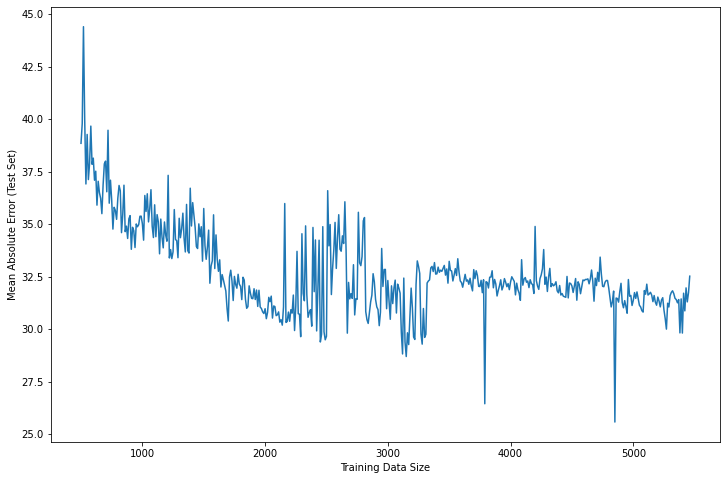

In [4]:
def training_size_analysis(step):
    """
    This function trains a vanilla LGB regression model by varying training size.
    Return a list of MAE score for plotting against sample size
    """
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = drone_group, shuffle = True)
    mae_score = []
    x_range = [x for x in range(500, len(X_train), step)]
    #vary training size
    for sample_size in x_range:
        x_train, y_train = X_train[:sample_size], Y_train[:sample_size]
        param = {'objective': 'regression_l1',
                 'metric': 'mae'}
        #instantiate vanilla model
        model = lgb.LGBMRegressor(**param)
        #train
        model.fit(x_train, y_train)
        #predict
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_true = Y_test, y_pred = y_pred)
        mae_score.append(mae)
    return mae_score, x_range

step = 10
mae, x_range = training_size_analysis(step)
plt.figure(figsize=(12, 8))
plt.plot(x_range, mae)
plt.xlabel('Training Data Size');
plt.ylabel('Mean Absolute Error (Test Set)');

General observation from plot:

1. As training data size increase, the test error MAE decreases
2. Test MSE does not improve above 3,000 training data in the model ($\frac{3000}{6832} \approx 43.9\%$)
3. For the combined dataset with equal proportion of drone represented, the MAE is about 35

## Optimizing LightGBM

Reference Code: [Source](https://www.analyticsvidhya.com/blog/2021/09/optimize-your-optimizations-using-optuna/#h2_12)

The default class constructor `LGBMRegressor` will be used. It automatically initializes model parameters and allow `fit`, `train` and `predict` methods. The procedure for implementing LightGBM is as follows:

1. Split the dataset into 80% train and 20% test set for each drone type
2. Split the trainset into 80% train and 20% validation set
3. Define the objective function, metric and parameters
4. Train the model using `lgbm_fit` function
5. Record the tuned hyperparameters from Optuna after the TPE algorithm
6. Repeat for other objective functions

Additional information:

1. The `log` argument in `trial.suggest` will sample low values more often than high values. Thus, it is used for `learning rate` and `min_split_gain`. A smaller learning rate helps ensure model convergence to a minimum point but at the cost of higher training time. 


2. There are two ways to reduce overfitting during hyperparameter optimization. Firstly, using K-fold cross validation to train the model. Secondly, apply early stopping technique that is used for bias-variance tradeoff. Due to limitation stated in point 3, early stopping will be used.


3. `optuna.integration.LightGBMPruningCallback()` does not currently support kfold cross validation. When using `cross_validation` from sklearn, the eval_set must be empty. However, lightGBM-Optuna is unable to stop early without an eval_set. Also, if eval_set was provided, the score of other folds will be ignored. When using `lightgbm.cv`, it does not allow stratifying of train-validation split by drone type.


4. For train-validation split, a random seed will be defined to ensure the test set is reproducible. The test set must not be used during training or hyperparameter optimization for validation purposes. 

In [5]:
#seed for reproducibility of test set
test_seed = 1111
valid_seed = 2222

#list of objectives
objective_list = {1: ('regression_l2', 'l2'), #l2 = mse 
                  2: ('regression_l1', 'l1'), #l1 = mae
                  3: ('huber', 'huber'),
                  4: ('quantile', 'quantile')}

objective_no = 1

def LGBM_tune_objective(trial: Trial):
    """
    This function takes the trial object from Optuna and uses the TPE algorithm
    to sample the hyperparameters. Returns the history of validation score to 
    Optuna for pruning.
    """
    #split train-test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = drone_group, shuffle = True, random_state = test_seed)
    X_train_drone_group = drone_group.loc[X_train.index]
    
    #split validation set
    x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2, stratify = X_train_drone_group, shuffle = True, random_state = valid_seed)

    #train model
    model, history = lgbm_fit(trial, x_train, x_valid, y_train, y_valid)
    
    #get validation score
    valid_score = history['valid']
    
    #return score to optuna
    return valid_score

quantile = 0.5
linear_tree = False

def lgbm_fit(trial, x_train, x_valid, y_train, y_valid):
    """
    This function takes the trial, train and validation set. 
    Return the trained model and history of validation score.
    """
    objective = objective_no
    lgb_objective = objective_list[objective][0]
    lgb_metric = objective_list[objective][1]
    
    param = {
        'objective': lgb_objective,
        'metric': lgb_metric,
        #PARAM THAT AFFECT TREE STRUCTURE
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 5, 8),
        #PARAM THAT AFFECT LEAF-WISE SPLITTING
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1.0, log = True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-1, 10.0, log = True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0, step = 0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step = 0.1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0, step = 0.1),
        #PARAM THAT AFFECT REGULARIZATION
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 100.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 100.0)
    }
    
    #maximum leaves = 2^(max_depth) * 0.7
    num_leaves_max = np.ceil(0.7 * 2**(param['max_depth']))
    if num_leaves_max <= 2: num_leaves_max == 3
    param['num_leaves'] = trial.suggest_int('num_leaves', 2, num_leaves_max)
    
    #huber parameter
    if lgb_objective == 'huber': 
        param['alpha'] = trial.suggest_float('alpha', 10.0, 30.0)
    
    #quantile parameter  
    alpha = quantile
    if lgb_objective == 'quantile':
        param['alpha'] = alpha
    
    #linear leaf function
    if linear_tree:
        param['linear_tree'] = linear_tree

    #instantiate model
    model = lgb.LGBMRegressor(**param)
    eval_set = [(x_train, y_train),(x_valid, y_valid)]
    
    #early callback via median pruning
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, metric = lgb_metric, valid_name = 'valid')
    
    #train
    model.fit(x_train, y_train, eval_set=eval_set, eval_names = ['train', 'valid'], callbacks=[pruning_callback])
    history = {'train': model.best_score_['train'][lgb_metric],
               'valid': model.best_score_['valid'][lgb_metric]}
    
    return model, history

###  Using the Mean Squared Loss Function

The Mean Squared loss function (MSE) is defined as $\mathcal{L} = ({y}_{i} - \hat{y}_{i})^{2}$. One disadvantage is that the MSE is sensitive to outliers. This is because the objective function calculates the square of the residual error and the model will attempt to incorporate outliers to reduce the error. 

In [6]:
%%time
#create pruner
objective_no = 1
LGBM_pruner = optuna.pruners.MedianPruner(n_startup_trials = 50, n_warmup_steps= 5)
#create study (default sampler = TPE, objective = MSE) 
LGBM_study1 = optuna.create_study(pruner=LGBM_pruner, direction ='minimize')
LGBM_study1.optimize(LGBM_tune_objective, n_trials = 100);

[I 2022-03-25 10:49:21,189] A new study created in memory with name: no-name-2877bf0e-c2c5-490a-9d08-5f1de1673c7b
[I 2022-03-25 10:49:21,347] Trial 0 finished with value: 36109.19023551538 and parameters: {'n_estimators': 202, 'max_depth': 6, 'learning_rate': 0.0035701566154919765, 'min_split_gain': 0.9157481509708129, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'colsample_bynode': 0.8, 'reg_alpha': 0.16626867151283697, 'reg_lambda': 83.94830383960785, 'num_leaves': 37}. Best is trial 0 with value: 36109.19023551538.
[I 2022-03-25 10:49:21,570] Trial 1 finished with value: 64097.08056102014 and parameters: {'n_estimators': 238, 'max_depth': 8, 'learning_rate': 0.0014340321510273285, 'min_split_gain': 3.287704636287508, 'subsample': 0.8, 'colsample_bytree': 0.5, 'colsample_bynode': 0.8, 'reg_alpha': 13.499998577149352, 'reg_lambda': 80.72998798479351, 'num_leaves': 72}. Best is trial 0 with value: 36109.19023551538.
[I 2022-03-25 10:49:21,757] Trial 2 finished with value: 

[I 2022-03-25 10:49:29,711] Trial 19 finished with value: 85747.85614542697 and parameters: {'n_estimators': 547, 'max_depth': 8, 'learning_rate': 0.00021820227208434734, 'min_split_gain': 0.29851361213623756, 'subsample': 0.5, 'colsample_bytree': 1.0, 'colsample_bynode': 0.5, 'reg_alpha': 77.52122000981598, 'reg_lambda': 12.70545939978837, 'num_leaves': 178}. Best is trial 18 with value: 2005.1602899375055.
[I 2022-03-25 10:49:30,705] Trial 20 finished with value: 105032.1207471121 and parameters: {'n_estimators': 716, 'max_depth': 8, 'learning_rate': 9.745806696556276e-06, 'min_split_gain': 0.40748490627675127, 'subsample': 0.8, 'colsample_bytree': 0.8, 'colsample_bynode': 0.4, 'reg_alpha': 88.9614384575668, 'reg_lambda': 2.0784776484931466, 'num_leaves': 172}. Best is trial 18 with value: 2005.1602899375055.
[I 2022-03-25 10:49:31,512] Trial 21 finished with value: 2431.0194590701612 and parameters: {'n_estimators': 574, 'max_depth': 8, 'learning_rate': 0.01324048065971361, 'min_spl

[I 2022-03-25 10:49:42,049] Trial 38 finished with value: 3875.7100768833348 and parameters: {'n_estimators': 549, 'max_depth': 6, 'learning_rate': 0.004581445862712242, 'min_split_gain': 1.1810789140976563, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bynode': 0.4, 'reg_alpha': 85.45239153246976, 'reg_lambda': 0.0689027477104327, 'num_leaves': 45}. Best is trial 18 with value: 2005.1602899375055.
[I 2022-03-25 10:49:42,466] Trial 39 finished with value: 61901.121143348646 and parameters: {'n_estimators': 327, 'max_depth': 8, 'learning_rate': 0.0009577772265202817, 'min_split_gain': 2.5751009188327623, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bynode': 0.6, 'reg_alpha': 73.5550624973677, 'reg_lambda': 16.535080478512924, 'num_leaves': 145}. Best is trial 18 with value: 2005.1602899375055.
[I 2022-03-25 10:49:43,177] Trial 40 finished with value: 3039.619880570979 and parameters: {'n_estimators': 717, 'max_depth': 7, 'learning_rate': 0.01592078357912

[I 2022-03-25 10:49:54,500] Trial 63 finished with value: 2132.4608968627754 and parameters: {'n_estimators': 616, 'max_depth': 8, 'learning_rate': 0.07341910984509087, 'min_split_gain': 0.8728834736471087, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bynode': 0.9, 'reg_alpha': 37.695794351395584, 'reg_lambda': 3.8828798879005553, 'num_leaves': 154}. Best is trial 48 with value: 1974.9931279777775.
[I 2022-03-25 10:49:54,568] Trial 64 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:49:55,776] Trial 65 finished with value: 1938.1097974261327 and parameters: {'n_estimators': 739, 'max_depth': 8, 'learning_rate': 0.046924298812463815, 'min_split_gain': 1.5461040289107806, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bynode': 0.8, 'reg_alpha': 53.28210522482429, 'reg_lambda': 3.3814278762984116, 'num_leaves': 143}. Best is trial 65 with value: 1938.1097974261327.
[I 2022-03-25 10:49:55,845] Trial 66 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:49:55

Wall time: 55.6 s


In [7]:
print('Hyperparameters: \n \n', LGBM_study1.best_trial.params)
print('\n')
print('Best MSE Value: \n \n', LGBM_study1.best_trial.value)
fig1 = optuna.visualization.plot_optimization_history(LGBM_study1, target_name="Mean Squared Error")
fig1.show()
fig2 = optuna.visualization.plot_param_importances(LGBM_study1, target_name="Mean Squared Error")
fig2.show()

Hyperparameters: 
 
 {'n_estimators': 771, 'max_depth': 8, 'learning_rate': 0.05251651464020028, 'min_split_gain': 0.1396496676480221, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bynode': 0.9, 'reg_alpha': 41.51648780386966, 'reg_lambda': 3.279783424866065, 'num_leaves': 141}


Best MSE Value: 
 
 1916.1696493910977


### Using the Mean Absolute Loss Function

The Mean Absolute loss function (MAE) is defined as $\mathcal{L} = |{y}_{i} - \hat{y}_{i}|$. The MAE minimizes the median value of the losses and is less sensitive to outliers compared to MSE. 

In statistical theory, the sample mean is the maximum likelihood expectation (MLE) under a normal distribution while the sample median is the MLE under a Laplace distribution. If the error distribution is not known, the median is a robust metric. However, if the error distribution is normal, the median is not as robust compared to the mean.

In [8]:
%%time
objective_no = 2
#create pruner
LGBM_pruner = optuna.pruners.MedianPruner(n_startup_trials = 50, n_warmup_steps= 5)
#create study (default sampler = TPE, objective = MAE) 
LGBM_study2 = optuna.create_study(pruner=LGBM_pruner, direction ='minimize')
LGBM_study2.optimize(LGBM_tune_objective, n_trials = 100);

[I 2022-03-25 10:50:19,629] A new study created in memory with name: no-name-60265b16-f4ae-4fc9-af54-14a36d2c0b36
[I 2022-03-25 10:50:19,732] Trial 0 finished with value: 165.91003419755873 and parameters: {'n_estimators': 128, 'max_depth': 5, 'learning_rate': 0.0038839629929679435, 'min_split_gain': 0.20256054346304045, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bynode': 0.6, 'reg_alpha': 14.6146337224054, 'reg_lambda': 69.48978144885331, 'num_leaves': 18}. Best is trial 0 with value: 165.91003419755873.
[I 2022-03-25 10:50:19,975] Trial 1 finished with value: 42.04094929557547 and parameters: {'n_estimators': 584, 'max_depth': 8, 'learning_rate': 0.5309764345870543, 'min_split_gain': 6.267767364622607, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.5, 'colsample_bynode': 0.8, 'reg_alpha': 6.989936917314498, 'reg_lambda': 35.51953402111165, 'num_leaves': 96}. Best is trial 1 with value: 42.04094929557547.
[I 2022-03-25 10:50:20,293] Trial 2 finished with value: 46.

[I 2022-03-25 10:50:25,206] Trial 19 finished with value: 34.16692686405777 and parameters: {'n_estimators': 284, 'max_depth': 7, 'learning_rate': 0.024156507473729674, 'min_split_gain': 0.1925903064422725, 'subsample': 0.1, 'colsample_bytree': 0.9, 'colsample_bynode': 0.7000000000000001, 'reg_alpha': 47.61742550277222, 'reg_lambda': 96.76053536230164, 'num_leaves': 59}. Best is trial 14 with value: 34.165240438532784.
[I 2022-03-25 10:50:25,458] Trial 20 finished with value: 254.581176620169 and parameters: {'n_estimators': 270, 'max_depth': 7, 'learning_rate': 1.1047139746445047e-06, 'min_split_gain': 1.3704703376754819, 'subsample': 1.0, 'colsample_bytree': 0.9, 'colsample_bynode': 0.7000000000000001, 'reg_alpha': 43.860833514951885, 'reg_lambda': 93.0538354394659, 'num_leaves': 53}. Best is trial 14 with value: 34.165240438532784.
[I 2022-03-25 10:50:25,769] Trial 21 finished with value: 30.508667670470295 and parameters: {'n_estimators': 420, 'max_depth': 7, 'learning_rate': 0.023

[I 2022-03-25 10:50:30,751] Trial 39 finished with value: 57.43191873242153 and parameters: {'n_estimators': 377, 'max_depth': 8, 'learning_rate': 0.006173143241563343, 'min_split_gain': 0.4977072570448477, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.5, 'colsample_bynode': 0.8, 'reg_alpha': 40.99828360052697, 'reg_lambda': 56.989417356545374, 'num_leaves': 144}. Best is trial 25 with value: 30.18036062201421.
[I 2022-03-25 10:50:31,145] Trial 40 finished with value: 34.13803302658845 and parameters: {'n_estimators': 564, 'max_depth': 8, 'learning_rate': 0.017746381156806424, 'min_split_gain': 0.3381178585004322, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bynode': 0.6, 'reg_alpha': 55.48861526254782, 'reg_lambda': 82.56559882257619, 'num_leaves': 100}. Best is trial 25 with value: 30.18036062201421.
[I 2022-03-25 10:50:31,433] Trial 41 finished with value: 28.875523097114506 and parameters: {'n_estimators': 360, 'max_depth': 8, 'learning_rate': 0.26271058776201756,

[I 2022-03-25 10:50:38,602] Trial 62 pruned. Trial was pruned at iteration 381.
[I 2022-03-25 10:50:39,420] Trial 63 finished with value: 28.059340545707006 and parameters: {'n_estimators': 628, 'max_depth': 8, 'learning_rate': 0.14821788858476256, 'min_split_gain': 0.13931396097875817, 'subsample': 0.1, 'colsample_bytree': 0.9, 'colsample_bynode': 1.0, 'reg_alpha': 8.690097450289977, 'reg_lambda': 71.8301369398163, 'num_leaves': 33}. Best is trial 63 with value: 28.059340545707006.
[I 2022-03-25 10:50:39,483] Trial 64 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:50:40,243] Trial 65 finished with value: 29.655752204363708 and parameters: {'n_estimators': 615, 'max_depth': 8, 'learning_rate': 0.11487218161865863, 'min_split_gain': 0.16842427624061118, 'subsample': 0.1, 'colsample_bytree': 1.0, 'colsample_bynode': 0.4, 'reg_alpha': 8.965424148185393, 'reg_lambda': 57.05098752943928, 'num_leaves': 25}. Best is trial 63 with value: 28.059340545707006.
[I 2022-03-25 10:50:40,84

[I 2022-03-25 10:50:57,367] Trial 98 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:50:57,533] Trial 99 pruned. Trial was pruned at iteration 76.


Wall time: 37.9 s


In [9]:
print('Hyperparameters: \n \n', LGBM_study2.best_trial.params)
print('\n')
print('Best MAE Value: \n \n', LGBM_study2.best_trial.value)
fig1 = optuna.visualization.plot_optimization_history(LGBM_study2, target_name="Mean Absolute Error")
fig1.show()
fig2 = optuna.visualization.plot_param_importances(LGBM_study2, target_name="Mean Absolute Error")
fig2.show()

Hyperparameters: 
 
 {'n_estimators': 576, 'max_depth': 8, 'learning_rate': 0.13821252693438402, 'min_split_gain': 0.25459583548539483, 'subsample': 0.1, 'colsample_bytree': 0.9, 'colsample_bynode': 0.5, 'reg_alpha': 6.220153372834579, 'reg_lambda': 66.59646681393095, 'num_leaves': 39}


Best MAE Value: 
 
 27.200092132375016


### Using the Huber Loss Function

Peter J. Huber developed the Huber loss function in 1981. The Huber loss function is a piecewise function $\mathcal{L} = \frac{1}{2}({y}_{i} - \hat{y}_{i})^2$ for $|{y}_{i} - \hat{y}_{i}| \leq \alpha$ and $\mathcal{L} = \alpha(|{y}_{i} - \hat{y}_{i}| - \frac{1}{2}\alpha)$ otherwise, where $\alpha$ is the error tolerance. According to Huber, robust regression is defined as the insensitivity of the model to small deviations of the model assumptions made on the data. Therefore, Huber loss combines the mean and median estimator so it does not make any assumptions about the underlying error distribution.

In [10]:
%%time
objective_no = 3
#create pruner
LGBM_pruner = optuna.pruners.MedianPruner(n_startup_trials = 50, n_warmup_steps= 5)
#create study (default sampler = TPE, objective = Huber) 
LGBM_study3 = optuna.create_study(pruner=LGBM_pruner, direction ='minimize')
LGBM_study3.optimize(LGBM_tune_objective, n_trials = 100);

[I 2022-03-25 10:50:59,166] A new study created in memory with name: no-name-99ba2a55-3dfb-4e6a-891c-de7d14fb9d0b
[I 2022-03-25 10:50:59,311] Trial 0 finished with value: 2629.8822899303145 and parameters: {'n_estimators': 344, 'max_depth': 5, 'learning_rate': 0.00046346377561510735, 'min_split_gain': 0.8983498503691838, 'subsample': 0.6, 'colsample_bytree': 0.5, 'colsample_bynode': 0.6, 'reg_alpha': 87.87058168600524, 'reg_lambda': 55.46986390854675, 'num_leaves': 13, 'alpha': 10.560674061895703}. Best is trial 0 with value: 2629.8822899303145.
[I 2022-03-25 10:50:59,462] Trial 1 finished with value: 5622.65322594705 and parameters: {'n_estimators': 202, 'max_depth': 7, 'learning_rate': 0.006796856559934398, 'min_split_gain': 0.31283204245149004, 'subsample': 0.4, 'colsample_bytree': 1.0, 'colsample_bynode': 0.4, 'reg_alpha': 87.74633232668853, 'reg_lambda': 40.29924531356248, 'num_leaves': 58, 'alpha': 25.472754979623073}. Best is trial 0 with value: 2629.8822899303145.
[I 2022-03-25

[I 2022-03-25 10:51:03,679] Trial 18 finished with value: 605.0744226206573 and parameters: {'n_estimators': 138, 'max_depth': 6, 'learning_rate': 0.43685641708508643, 'min_split_gain': 6.862875349626551, 'subsample': 1.0, 'colsample_bytree': 0.6, 'colsample_bynode': 0.2, 'reg_alpha': 28.04882183648337, 'reg_lambda': 63.71996968151021, 'num_leaves': 23, 'alpha': 20.75836076341389}. Best is trial 8 with value: 498.8104190189996.
[I 2022-03-25 10:51:04,085] Trial 19 finished with value: 2751.7477060581623 and parameters: {'n_estimators': 387, 'max_depth': 7, 'learning_rate': 0.03139834092560815, 'min_split_gain': 2.8127618282443003, 'subsample': 0.8, 'colsample_bytree': 0.8, 'colsample_bynode': 0.4, 'reg_alpha': 36.675329067078636, 'reg_lambda': 85.61811815286741, 'num_leaves': 54, 'alpha': 27.31776646506153}. Best is trial 8 with value: 498.8104190189996.
[I 2022-03-25 10:51:04,210] Trial 20 finished with value: 5976.145982980748 and parameters: {'n_estimators': 177, 'max_depth': 5, 'le

[I 2022-03-25 10:51:11,427] Trial 36 finished with value: 2779.7540088826113 and parameters: {'n_estimators': 570, 'max_depth': 7, 'learning_rate': 0.015638688683363704, 'min_split_gain': 0.1875160338679692, 'subsample': 0.1, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'reg_alpha': 84.84729439809708, 'reg_lambda': 6.696702379889063, 'num_leaves': 46, 'alpha': 18.20008007483803}. Best is trial 31 with value: 307.5196615608057.
[I 2022-03-25 10:51:12,147] Trial 37 finished with value: 316.6356123841009 and parameters: {'n_estimators': 656, 'max_depth': 8, 'learning_rate': 0.09561077969334311, 'min_split_gain': 0.43809041587273123, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bynode': 0.9, 'reg_alpha': 72.812044834225, 'reg_lambda': 21.623802802904315, 'num_leaves': 109, 'alpha': 14.934371876358174}. Best is trial 31 with value: 307.5196615608057.
[I 2022-03-25 10:51:12,813] Trial 38 finished with value: 293.5391778188394 and parameters: {'n_estimators': 650, 'max_depth': 8

[I 2022-03-25 10:51:24,741] Trial 57 pruned. Trial was pruned at iteration 585.
[I 2022-03-25 10:51:25,518] Trial 58 pruned. Trial was pruned at iteration 656.
[I 2022-03-25 10:51:26,333] Trial 59 pruned. Trial was pruned at iteration 592.
[I 2022-03-25 10:51:26,855] Trial 60 pruned. Trial was pruned at iteration 508.
[I 2022-03-25 10:51:27,495] Trial 61 pruned. Trial was pruned at iteration 672.
[I 2022-03-25 10:51:28,223] Trial 62 pruned. Trial was pruned at iteration 656.
[I 2022-03-25 10:51:29,129] Trial 63 finished with value: 256.0170541222042 and parameters: {'n_estimators': 623, 'max_depth': 8, 'learning_rate': 0.23178135570895114, 'min_split_gain': 2.2169078760519643, 'subsample': 0.4, 'colsample_bytree': 0.4, 'colsample_bynode': 0.5, 'reg_alpha': 33.47943412959029, 'reg_lambda': 47.23524115977493, 'num_leaves': 135, 'alpha': 10.507591444474697}. Best is trial 41 with value: 226.51343277291585.
[I 2022-03-25 10:51:29,932] Trial 64 pruned. Trial was pruned at iteration 608.
[I 

[I 2022-03-25 10:51:47,737] Trial 98 pruned. Trial was pruned at iteration 546.
[I 2022-03-25 10:51:47,819] Trial 99 pruned. Trial was pruned at iteration 5.


Wall time: 48.7 s


In [11]:
print('Hyperparameters: \n \n', LGBM_study3.best_trial.params)
print('\n')
print('Best Huber Loss: \n \n', LGBM_study3.best_trial.value)
fig1 = optuna.visualization.plot_optimization_history(LGBM_study3, target_name="Huber Loss")
fig1.show()
fig2 = optuna.visualization.plot_param_importances(LGBM_study3, target_name="Huber Loss")
fig2.show()

Hyperparameters: 
 
 {'n_estimators': 686, 'max_depth': 8, 'learning_rate': 0.11755151647521327, 'min_split_gain': 0.4587904671746516, 'subsample': 0.2, 'colsample_bytree': 0.7000000000000001, 'colsample_bynode': 0.9, 'reg_alpha': 73.57477630308118, 'reg_lambda': 25.571948176736853, 'num_leaves': 60, 'alpha': 10.178085766843662}


Best Huber Loss: 
 
 226.51343277291585


### Using the Quantile Loss Function

The Quantile loss function is defined as $\mathcal{L} = \alpha({y}_{i} - \hat{y}_{i})$ if ${y}_{i} \geq \hat{y}_{i}$ and $\mathcal{L} = (1-\alpha)({y}_{i} - \hat{y}_{i})$ if ${y}_{i} \lt \hat{y}_{i}$ where $0 \lt \alpha \lt 1$. $\alpha$ is the quantile of the conditional distribution $(Y | x)$ that gives $P(Y \lt y_{i} | x_{i}) = \alpha$.

When $\alpha = 0.5$, the loss function is symmetric about zero and is equivalent to minimizing the MAE. The quantile loss function is especially useful for predicting power under uncertainty. The model hyperparameter must be tuned for each quantile value. The detailed implementation of quantile regression in lightGBM is given in [source](http://jmarkhou.com/lgbqr/).

In [12]:
%%time
objective_no = 4
quantile_list = [0.1, 0.5, 0.9]
quantile_study = {}
for i, var in enumerate(quantile_list):
    quantile = var
    #create pruner
    LGBM_pruner = optuna.pruners.MedianPruner(n_startup_trials = 50, n_warmup_steps= 5)
    #create study (default sampler = TPE, objective = quantile) 
    LGBM_quantile = optuna.create_study(pruner=LGBM_pruner, direction ='minimize')
    LGBM_quantile.optimize(LGBM_tune_objective, n_trials = 100);
    quantile_study[i] = LGBM_quantile

[I 2022-03-25 10:51:49,431] A new study created in memory with name: no-name-02f4ea47-971f-4301-be98-4ec200fbb89e
[I 2022-03-25 10:51:49,676] Trial 0 finished with value: 31.729831464042444 and parameters: {'n_estimators': 672, 'max_depth': 5, 'learning_rate': 0.0015150367945294112, 'min_split_gain': 0.27561584717477744, 'subsample': 0.4, 'colsample_bytree': 0.4, 'colsample_bynode': 0.30000000000000004, 'reg_alpha': 8.694302010850253, 'reg_lambda': 64.68239643992825, 'num_leaves': 22}. Best is trial 0 with value: 31.729831464042444.
[I 2022-03-25 10:51:49,823] Trial 1 finished with value: 44.58082624230083 and parameters: {'n_estimators': 416, 'max_depth': 5, 'learning_rate': 1.605698537729089e-06, 'min_split_gain': 1.979559396496612, 'subsample': 0.1, 'colsample_bytree': 0.4, 'colsample_bynode': 0.1, 'reg_alpha': 23.980942518843896, 'reg_lambda': 55.34966380569244, 'num_leaves': 8}. Best is trial 0 with value: 31.729831464042444.
[I 2022-03-25 10:51:49,906] Trial 2 finished with value

[I 2022-03-25 10:51:53,146] Trial 19 finished with value: 19.544240003778295 and parameters: {'n_estimators': 717, 'max_depth': 8, 'learning_rate': 0.030056345412280264, 'min_split_gain': 0.49671595042756905, 'subsample': 0.6, 'colsample_bytree': 0.1, 'colsample_bynode': 0.6, 'reg_alpha': 60.66345833138595, 'reg_lambda': 5.926900956776123, 'num_leaves': 179}. Best is trial 11 with value: 10.711359524501841.
[I 2022-03-25 10:51:53,274] Trial 20 finished with value: 32.2583208247674 and parameters: {'n_estimators': 195, 'max_depth': 7, 'learning_rate': 0.005783074664580808, 'min_split_gain': 1.2999705271887436, 'subsample': 0.30000000000000004, 'colsample_bytree': 1.0, 'colsample_bynode': 0.1, 'reg_alpha': 33.435360962991055, 'reg_lambda': 63.006398187575236, 'num_leaves': 59}. Best is trial 11 with value: 10.711359524501841.
[I 2022-03-25 10:51:53,580] Trial 21 finished with value: 10.723196950841537 and parameters: {'n_estimators': 794, 'max_depth': 8, 'learning_rate': 0.11771498479592

[I 2022-03-25 10:51:58,232] Trial 39 finished with value: 21.57152429319017 and parameters: {'n_estimators': 535, 'max_depth': 6, 'learning_rate': 0.03266587938597154, 'min_split_gain': 0.48846288055160264, 'subsample': 0.6, 'colsample_bytree': 0.30000000000000004, 'colsample_bynode': 0.7000000000000001, 'reg_alpha': 14.744703378029524, 'reg_lambda': 85.98480019725956, 'num_leaves': 45}. Best is trial 25 with value: 9.29255379473863.
[I 2022-03-25 10:51:58,422] Trial 40 finished with value: 44.583711219976365 and parameters: {'n_estimators': 429, 'max_depth': 8, 'learning_rate': 1.0273984842926174e-06, 'min_split_gain': 0.23784280077706557, 'subsample': 1.0, 'colsample_bytree': 0.4, 'colsample_bynode': 0.9, 'reg_alpha': 39.37832033099322, 'reg_lambda': 77.16540337909373, 'num_leaves': 150}. Best is trial 25 with value: 9.29255379473863.
[I 2022-03-25 10:51:58,659] Trial 41 finished with value: 10.885162404518203 and parameters: {'n_estimators': 595, 'max_depth': 8, 'learning_rate': 0.4

[I 2022-03-25 10:52:04,613] Trial 65 finished with value: 8.725714639321051 and parameters: {'n_estimators': 723, 'max_depth': 8, 'learning_rate': 0.1732031910168243, 'min_split_gain': 0.20028015784464745, 'subsample': 0.8, 'colsample_bytree': 0.6, 'colsample_bynode': 0.5, 'reg_alpha': 4.0660986421777565, 'reg_lambda': 95.60095559211192, 'num_leaves': 40}. Best is trial 53 with value: 7.64814401649093.
[I 2022-03-25 10:52:04,704] Trial 66 pruned. Trial was pruned at iteration 62.
[I 2022-03-25 10:52:05,286] Trial 67 finished with value: 8.383337589967041 and parameters: {'n_estimators': 733, 'max_depth': 8, 'learning_rate': 0.20855083532531804, 'min_split_gain': 0.1165869054293558, 'subsample': 0.8, 'colsample_bytree': 0.6, 'colsample_bynode': 0.5, 'reg_alpha': 4.004068060925822, 'reg_lambda': 89.06952203248449, 'num_leaves': 48}. Best is trial 53 with value: 7.64814401649093.
[I 2022-03-25 10:52:05,607] Trial 68 finished with value: 8.87576015706132 and parameters: {'n_estimators': 37

[I 2022-03-25 10:52:15,055] Trial 95 finished with value: 8.879777437471217 and parameters: {'n_estimators': 657, 'max_depth': 7, 'learning_rate': 0.22614015704589469, 'min_split_gain': 0.13033217813169712, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bynode': 0.4, 'reg_alpha': 4.420611445643655, 'reg_lambda': 89.61564185230557, 'num_leaves': 43}. Best is trial 53 with value: 7.64814401649093.
[I 2022-03-25 10:52:15,529] Trial 96 finished with value: 8.469958272119495 and parameters: {'n_estimators': 430, 'max_depth': 7, 'learning_rate': 0.17141689291911855, 'min_split_gain': 0.16131932354749132, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.7000000000000001, 'colsample_bynode': 0.4, 'reg_alpha': 0.32828614004714574, 'reg_lambda': 0.4804556476145123, 'num_leaves': 47}. Best is trial 53 with value: 7.64814401649093.
[I 2022-03-25 10:52:15,595] Trial 97 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:52:15,748] Trial 98 pruned. Trial was pruned at iteration 13

[I 2022-03-25 10:52:19,764] Trial 16 finished with value: 19.030027285025035 and parameters: {'n_estimators': 631, 'max_depth': 8, 'learning_rate': 0.1298373240649003, 'min_split_gain': 0.658457322799954, 'subsample': 0.4, 'colsample_bytree': 0.6, 'colsample_bynode': 0.1, 'reg_alpha': 7.098118590255735, 'reg_lambda': 57.11910688130872, 'num_leaves': 176}. Best is trial 15 with value: 16.757176077692748.
[I 2022-03-25 10:52:20,121] Trial 17 finished with value: 16.51708062602337 and parameters: {'n_estimators': 620, 'max_depth': 8, 'learning_rate': 0.05017120736977607, 'min_split_gain': 0.41799940448198086, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bynode': 0.2, 'reg_alpha': 1.3563518951593778, 'reg_lambda': 55.42982971083177, 'num_leaves': 134}. Best is trial 17 with value: 16.51708062602337.
[I 2022-03-25 10:52:20,468] Trial 18 finished with value: 16.57320643522576 and parameters: {'n_estimators': 571, 'max_depth': 8, 'learning_rate': 0.03286770768523946, 'min_split_gain'

[I 2022-03-25 10:52:26,281] Trial 36 finished with value: 17.87471677480613 and parameters: {'n_estimators': 519, 'max_depth': 8, 'learning_rate': 0.01456410827624477, 'min_split_gain': 1.219842526119626, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bynode': 0.4, 'reg_alpha': 0.39951897709528444, 'reg_lambda': 73.26590915087773, 'num_leaves': 99}. Best is trial 17 with value: 16.51708062602337.
[I 2022-03-25 10:52:26,617] Trial 37 finished with value: 16.91231687534996 and parameters: {'n_estimators': 678, 'max_depth': 7, 'learning_rate': 0.0626113095406014, 'min_split_gain': 0.10132940382708833, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.4, 'colsample_bynode': 1.0, 'reg_alpha': 21.179187716867535, 'reg_lambda': 45.11927657420647, 'num_leaves': 89}. Best is trial 17 with value: 16.51708062602337.
[I 2022-03-25 10:52:26,846] Trial 38 finished with value: 18.935274406703833 and parameters: {'n_estimators': 417, 'max_depth': 8, 'learning_rate': 0.12775228827859186, '

[I 2022-03-25 10:52:34,436] Trial 56 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:52:34,504] Trial 57 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:52:34,567] Trial 58 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:52:34,631] Trial 59 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:52:34,699] Trial 60 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:52:34,765] Trial 61 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:52:35,378] Trial 62 finished with value: 16.260104297216717 and parameters: {'n_estimators': 696, 'max_depth': 8, 'learning_rate': 0.10174392330766184, 'min_split_gain': 0.4268989891538785, 'subsample': 0.4, 'colsample_bytree': 0.7000000000000001, 'colsample_bynode': 0.30000000000000004, 'reg_alpha': 3.6550023300605377, 'reg_lambda': 97.8502936117907, 'num_leaves': 119}. Best is trial 54 with value: 14.920405973345433.
[I 2022-03-25 10:52:35,951] Trial 63 finished with value: 18.009740120622983 and parameters:

[I 2022-03-25 10:52:46,753] Trial 89 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:52:47,497] Trial 90 finished with value: 16.27966120148247 and parameters: {'n_estimators': 796, 'max_depth': 5, 'learning_rate': 0.14743684713628877, 'min_split_gain': 0.22620126947651303, 'subsample': 0.5, 'colsample_bytree': 0.6, 'colsample_bynode': 0.5, 'reg_alpha': 24.317224129655916, 'reg_lambda': 84.0847831864732, 'num_leaves': 22}. Best is trial 54 with value: 14.920405973345433.
[I 2022-03-25 10:52:48,120] Trial 91 finished with value: 16.573792162297067 and parameters: {'n_estimators': 652, 'max_depth': 5, 'learning_rate': 0.07146836739479673, 'min_split_gain': 0.3601869756380633, 'subsample': 0.5, 'colsample_bytree': 0.6, 'colsample_bynode': 0.6, 'reg_alpha': 15.634443638112897, 'reg_lambda': 74.45708344269957, 'num_leaves': 23}. Best is trial 54 with value: 14.920405973345433.
[I 2022-03-25 10:52:48,857] Trial 92 finished with value: 15.584111177103097 and parameters: {'n_estimato

[I 2022-03-25 10:52:52,634] Trial 14 finished with value: 25.801854128196535 and parameters: {'n_estimators': 323, 'max_depth': 5, 'learning_rate': 0.00893520707642213, 'min_split_gain': 0.46917005930700395, 'subsample': 0.8, 'colsample_bytree': 0.6, 'colsample_bynode': 0.5, 'reg_alpha': 12.024682359304315, 'reg_lambda': 53.12460649245132, 'num_leaves': 19}. Best is trial 11 with value: 7.23647107450259.
[I 2022-03-25 10:52:52,874] Trial 15 finished with value: 48.95423669275584 and parameters: {'n_estimators': 507, 'max_depth': 5, 'learning_rate': 0.000604756330593701, 'min_split_gain': 0.4616065589919245, 'subsample': 0.9, 'colsample_bytree': 0.8, 'colsample_bynode': 0.6, 'reg_alpha': 14.638719149228274, 'reg_lambda': 82.42749848166756, 'num_leaves': 16}. Best is trial 11 with value: 7.23647107450259.
[I 2022-03-25 10:52:52,995] Trial 16 finished with value: 23.087011235157973 and parameters: {'n_estimators': 419, 'max_depth': 8, 'learning_rate': 0.15733940453094516, 'min_split_gain'

[I 2022-03-25 10:52:56,005] Trial 33 finished with value: 9.719092937202978 and parameters: {'n_estimators': 345, 'max_depth': 5, 'learning_rate': 0.4756723374534016, 'min_split_gain': 0.670891710439242, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bynode': 0.6, 'reg_alpha': 8.543989278267842, 'reg_lambda': 78.65351345083037, 'num_leaves': 8}. Best is trial 11 with value: 7.23647107450259.
[I 2022-03-25 10:52:56,113] Trial 34 finished with value: 15.677452270127388 and parameters: {'n_estimators': 279, 'max_depth': 6, 'learning_rate': 0.17864244083712696, 'min_split_gain': 0.9785906479150045, 'subsample': 0.6, 'colsample_bytree': 0.6, 'colsample_bynode': 0.7000000000000001, 'reg_alpha': 23.206437464362587, 'reg_lambda': 85.71644918193202, 'num_leaves': 4}. Best is trial 11 with value: 7.23647107450259.
[I 2022-03-25 10:52:56,207] Trial 35 finished with value: 19.077370654266506 and parameters: {'n_estimators': 199, 'max_depth': 5, 'learning_rate': 0.7357724195975714, 'min_spli

[I 2022-03-25 10:53:00,027] Trial 53 finished with value: 8.595225761840389 and parameters: {'n_estimators': 367, 'max_depth': 5, 'learning_rate': 0.16193770927432094, 'min_split_gain': 0.14134641175223003, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bynode': 0.4, 'reg_alpha': 12.86516015999033, 'reg_lambda': 24.39698994500735, 'num_leaves': 13}. Best is trial 11 with value: 7.23647107450259.
[I 2022-03-25 10:53:00,088] Trial 54 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:53:00,149] Trial 55 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:53:00,361] Trial 56 pruned. Trial was pruned at iteration 271.
[I 2022-03-25 10:53:00,543] Trial 57 pruned. Trial was pruned at iteration 266.
[I 2022-03-25 10:53:00,605] Trial 58 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:53:01,031] Trial 59 finished with value: 7.660655357425543 and parameters: {'n_estimators': 528, 'max_depth': 5, 'learning_rate': 0.08048983290195025, 'min_split_gain': 0.341343475735

[I 2022-03-25 10:53:09,456] Trial 92 finished with value: 7.906862644001043 and parameters: {'n_estimators': 771, 'max_depth': 7, 'learning_rate': 0.10991229843611391, 'min_split_gain': 0.14058589207823446, 'subsample': 0.9, 'colsample_bytree': 0.6, 'colsample_bynode': 0.7000000000000001, 'reg_alpha': 8.54255557628448, 'reg_lambda': 50.60420919717122, 'num_leaves': 42}. Best is trial 80 with value: 6.873270917996109.
[I 2022-03-25 10:53:09,682] Trial 93 pruned. Trial was pruned at iteration 251.
[I 2022-03-25 10:53:09,746] Trial 94 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:53:09,810] Trial 95 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:53:09,874] Trial 96 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:53:10,574] Trial 97 finished with value: 6.908994923191578 and parameters: {'n_estimators': 726, 'max_depth': 7, 'learning_rate': 0.09600043087875414, 'min_split_gain': 0.1400128077609613, 'subsample': 0.9, 'colsample_bytree': 0.7000000000000001, '

Wall time: 1min 22s


In [13]:
for i in range(3):
    print('Quantile: \n \n ' + str(quantile_list[i]))
    print('\n')
    print('Hyperparameters: \n \n', quantile_study[i].best_trial.params)
    print('\n')
    print('Best Quantile Error: \n \n', quantile_study[i].best_trial.value)
    fig1 = optuna.visualization.plot_optimization_history(quantile_study[i], target_name="Quantile Error")
    fig1.show()
    fig2 = optuna.visualization.plot_param_importances(quantile_study[i], target_name="Quantile Error")
    fig2.show()

Quantile: 
 
 0.1


Hyperparameters: 
 
 {'n_estimators': 661, 'max_depth': 8, 'learning_rate': 0.12834399886835557, 'min_split_gain': 0.20467965670020832, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.6, 'colsample_bynode': 0.6, 'reg_alpha': 0.2407676020352767, 'reg_lambda': 84.91630578159659, 'num_leaves': 50}


Best Quantile Error: 
 
 7.64814401649093


Quantile: 
 
 0.5


Hyperparameters: 
 
 {'n_estimators': 771, 'max_depth': 8, 'learning_rate': 0.02367604576762239, 'min_split_gain': 0.537718730015741, 'subsample': 0.5, 'colsample_bytree': 0.7000000000000001, 'colsample_bynode': 0.30000000000000004, 'reg_alpha': 0.1670941366297709, 'reg_lambda': 81.44508493673695, 'num_leaves': 150}


Best Quantile Error: 
 
 14.920405973345433


Quantile: 
 
 0.9


Hyperparameters: 
 
 {'n_estimators': 626, 'max_depth': 7, 'learning_rate': 0.09724092433454179, 'min_split_gain': 0.1376198605283893, 'subsample': 0.8, 'colsample_bytree': 0.7000000000000001, 'colsample_bynode': 0.6, 'reg_alpha': 0.05502863624044846, 'reg_lambda': 42.62626004560948, 'num_leaves': 38}


Best Quantile Error: 
 
 6.873270917996109


### Using Linear Leaf Functions

All the tree models above are build using leaf with constant value. However, it is possible to build leaf with linear functions of the features. A tree with linear leaf will be compared with a tree with constant leaf using the mean squared error loss function. After hypertuning, the MSE error and time cost will be compared.

In [14]:
%%time
#create pruner
objective_no = 1
linear_tree = True
LGBM_pruner = optuna.pruners.MedianPruner(n_startup_trials = 50, n_warmup_steps= 5)
#create study (default sampler = TPE, objective = MSE) 
LGBM_study4 = optuna.create_study(pruner=LGBM_pruner, direction ='minimize')
LGBM_study4.optimize(LGBM_tune_objective, n_trials = 100);
linear_tree = False

[I 2022-03-25 10:53:16,613] A new study created in memory with name: no-name-66aa85b6-6ddf-44aa-9dc1-98a08ba37830
[I 2022-03-25 10:53:16,872] Trial 0 finished with value: 101547.52155603956 and parameters: {'n_estimators': 717, 'max_depth': 5, 'learning_rate': 5.274760527849837e-05, 'min_split_gain': 0.5456734907220151, 'subsample': 0.1, 'colsample_bytree': 0.6, 'colsample_bynode': 0.9, 'reg_alpha': 25.03402510055427, 'reg_lambda': 54.67808051886922, 'num_leaves': 3}. Best is trial 0 with value: 101547.52155603956.
[I 2022-03-25 10:53:17,103] Trial 1 finished with value: 1635150221.6258721 and parameters: {'n_estimators': 228, 'max_depth': 6, 'learning_rate': 0.35629733943179603, 'min_split_gain': 0.6240922566305873, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bynode': 0.30000000000000004, 'reg_alpha': 22.820973856072534, 'reg_lambda': 47.4741197777929, 'num_leaves': 25}. Best is trial 0 with value: 101547.52155603956.
[I 2022-03-25 10:53:17,340] Trial 2 finished with value: 

[I 2022-03-25 10:53:25,166] Trial 19 finished with value: 106309.16456846429 and parameters: {'n_estimators': 616, 'max_depth': 6, 'learning_rate': 1.1445266053492853e-06, 'min_split_gain': 3.442078335085213, 'subsample': 0.4, 'colsample_bytree': 0.1, 'colsample_bynode': 0.2, 'reg_alpha': 34.28248030454911, 'reg_lambda': 19.73507977895334, 'num_leaves': 17}. Best is trial 9 with value: 2842.450707562115.
[I 2022-03-25 10:53:25,653] Trial 20 finished with value: 54488.14801751699 and parameters: {'n_estimators': 648, 'max_depth': 5, 'learning_rate': 0.0006542155261687841, 'min_split_gain': 1.192777342384859, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bynode': 0.4, 'reg_alpha': 12.012378555891274, 'reg_lambda': 3.838608587076072, 'num_leaves': 10}. Best is trial 9 with value: 2842.450707562115.
[I 2022-03-25 10:53:25,904] Trial 21 finished with value: 2566.3890283617375 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.14437943317309082, 'min_split_gain'

[I 2022-03-25 10:53:35,864] Trial 39 finished with value: 8.47140678543443e+16 and parameters: {'n_estimators': 799, 'max_depth': 6, 'learning_rate': 0.032767306734238735, 'min_split_gain': 0.30104678097701976, 'subsample': 0.4, 'colsample_bytree': 0.30000000000000004, 'colsample_bynode': 0.9, 'reg_alpha': 72.01404461514156, 'reg_lambda': 57.06570043114746, 'num_leaves': 17}. Best is trial 32 with value: 2031.213037404737.
[I 2022-03-25 10:53:36,335] Trial 40 finished with value: 3796.8402492038913 and parameters: {'n_estimators': 622, 'max_depth': 7, 'learning_rate': 0.16865052517108936, 'min_split_gain': 0.8347537607371748, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.5, 'colsample_bynode': 0.8, 'reg_alpha': 91.18675712162529, 'reg_lambda': 64.72835964630228, 'num_leaves': 43}. Best is trial 32 with value: 2031.213037404737.
[I 2022-03-25 10:53:36,761] Trial 41 finished with value: 39398.80406456017 and parameters: {'n_estimators': 521, 'max_depth': 6, 'learning_rate': 0.4

[I 2022-03-25 10:53:44,909] Trial 63 finished with value: 317379.55658036156 and parameters: {'n_estimators': 389, 'max_depth': 5, 'learning_rate': 0.08190882924049639, 'min_split_gain': 0.12734288093276253, 'subsample': 0.4, 'colsample_bytree': 0.4, 'colsample_bynode': 0.9, 'reg_alpha': 57.29906431287859, 'reg_lambda': 8.688945652725135, 'num_leaves': 16}. Best is trial 32 with value: 2031.213037404737.
[I 2022-03-25 10:53:44,976] Trial 64 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:53:45,046] Trial 65 pruned. Trial was pruned at iteration 5.
[I 2022-03-25 10:53:45,484] Trial 66 finished with value: 2769.1245361800443 and parameters: {'n_estimators': 444, 'max_depth': 6, 'learning_rate': 0.3237867477938516, 'min_split_gain': 0.3534510112740701, 'subsample': 0.5, 'colsample_bytree': 0.30000000000000004, 'colsample_bynode': 0.8, 'reg_alpha': 19.24661641039915, 'reg_lambda': 25.23202022420202, 'num_leaves': 9}. Best is trial 32 with value: 2031.213037404737.
[I 2022-03-25 1

[I 2022-03-25 10:53:52,383] Trial 86 finished with value: 259780.57268953137 and parameters: {'n_estimators': 390, 'max_depth': 6, 'learning_rate': 0.9600170389295182, 'min_split_gain': 0.4500185851649993, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bynode': 0.9, 'reg_alpha': 30.937697117532437, 'reg_lambda': 6.317109707348557, 'num_leaves': 7}. Best is trial 32 with value: 2031.213037404737.
[I 2022-03-25 10:53:52,561] Trial 87 finished with value: 2474.349111185084 and parameters: {'n_estimators': 124, 'max_depth': 6, 'learning_rate': 0.25852498546841435, 'min_split_gain': 0.6315424861755867, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bynode': 0.9, 'reg_alpha': 36.590993692681764, 'reg_lambda': 21.964607799384005, 'num_leaves': 6}. Best is trial 32 with value: 2031.213037404737.
[I 2022-03-25 10:53:52,780] Trial 88 finished with value: 2615.7222014780764 and parameters: {'n_estimators': 207, 'max_depth': 6, 'learning_rate': 0.441944726135149, 'min_split_gain': 1.

Wall time: 38 s


In [15]:
print('Hyperparameters: \n \n', LGBM_study4.best_trial.params)
print('\n')
print('Best MSE Value: \n \n', LGBM_study4.best_trial.value)
fig1 = optuna.visualization.plot_optimization_history(LGBM_study4, target_name="Mean Squared Error")
fig1.show()
fig2 = optuna.visualization.plot_param_importances(LGBM_study4, target_name="Mean Squared Error")
fig2.show()

Hyperparameters: 
 
 {'n_estimators': 679, 'max_depth': 6, 'learning_rate': 0.03690282764683963, 'min_split_gain': 0.5369298998787998, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bynode': 0.8, 'reg_alpha': 70.19688219991052, 'reg_lambda': 51.25627636385773, 'num_leaves': 16}


Best MSE Value: 
 
 2031.213037404737


Comparison of linear with constant leaf function:

1. Using linear leaf, the MSE is very close to the constant leaf MSE.

2. A linear leaf requires less depth than a constant leaf model. According to Occam's razor, a model that explains the data with the least complexity is better. Therefore, the constant leaf model is preferred.

3. There is one limitation for linear leaf function that does not happen to constant leaf. The mean absolute error cannot be used. This is because the second derivative of MAE loss is zero and cannot be used to construct a linear function.

## Prediction Analysis

With the hyperparameters found, the model is ready to predict power. To compare the models, R-squared, mean squared error and mean absolute error will be used.

1. Define the model, objective function and hyperparameters
2. Train the model with early stopping
3. Predict the power using test set (not used in hyperparameter tuning)
4. Compare the R-squared for different objective function
5. Determine which points were extrapolated during a prediction
6. Visualize the predicted power for each model for a full flight using plot
7. Visualize the residual/error plot against predicted power

Note: 

1. The saved param list below is a snapshot and may be slightly different than the code above because kernel is restarted and cell may be executed again.
2. When training the model, the early stopping is applied on their respective loss function metric. 


### Model Training 

In [16]:
param_list = {
    'mse': {'objective': 'regression_l2', 'metric': 'l2'},
    'mae': {'objective': 'regression_l1', 'metric': 'l1'},
    'huber': {'objective': 'huber', 'metric': 'huber'},
    'quantile_0.1': {'objective': 'quantile', 'metric': 'quantile', 'alpha': 0.1},
    'quantile_0.5': {'objective': 'quantile', 'metric': 'quantile', 'alpha': 0.5},
    'quantile_0.9': {'objective': 'quantile', 'metric': 'quantile', 'alpha': 0.9},
    'mse_lineartree': {'objective': 'regression_l2', 'metric': 'l2', 'linear_tree': True}
}

for name,key in LGBM_study1.best_trial.params.items():
    param_list['mse'][name] = key
for name,key in LGBM_study2.best_trial.params.items():
    param_list['mae'][name] = key
for name,key in LGBM_study3.best_trial.params.items():
    param_list['huber'][name] = key
for name,key in LGBM_study4.best_trial.params.items():
    param_list['mse_lineartree'][name] = key
for i, var in enumerate(quantile_list):
    for name,key in quantile_study[i].best_trial.params.items():
        param_list['quantile_'+str(var)][name] = key

In [17]:
test_seed = 1111
early_stopping_rounds = 30

def train_LGBM(best_params, x_train, x_valid, y_train, y_valid):
    """
    Returns a trained LightGBM model using the best hyperparameter
    """
    #instantiate model
    model = lgb.LGBMRegressor(**best_params)
    eval_set = [(x_train, y_train), (x_valid, y_valid)]
    
    #custom early stopping
    early_callback = [lgb.early_stopping(early_stopping_rounds, verbose=0), lgb.log_evaluation(period=0)]
    
    #train
    model.fit(x_train, y_train, eval_set = eval_set, eval_names = ['train', 'valid'], callbacks = early_callback)
    history = {'train': model.evals_result_['train'][best_params['metric']],
               'valid': model.evals_result_['valid'][best_params['metric']]}
    
    return model, history

### Comparison of R-Squared Score on Test Set

In [18]:
model_list = {}
score_list = {}
history_list = {}

#for objective comparison
multi_index = [np.array(['mae']*3 + ['mse']*3 + ['huber']*3 + ['quantile_0.1']*3 + ['quantile_0.5']*3 + ['quantile_0.9']*3 + ['mse_lineartree']*3),
    np.array(['r2', 'mae', 'mse']*7)]
summary = pd.DataFrame(index = multi_index, columns = ['overall score'])

#split train-test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = drone_group, shuffle = True, random_state = test_seed)
X_train_group = drone_group.loc[X_train.index]

for name, param in param_list.items():
    #validation set
    x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2, stratify = X_train_group, shuffle = True, random_state = valid_seed)
    
    #train model
    model, history = train_LGBM(param, x_train, x_valid, y_train, y_valid)
    
    #predict
    Y_test_pred = model.predict(X_test)
    
    #evaluate score on test set
    r2_test_score = r2_score(y_true = Y_test, y_pred = Y_test_pred)
    mse_test_score = mean_squared_error(y_true = Y_test, y_pred = Y_test_pred)
    mae_test_score = mean_absolute_error(y_true = Y_test, y_pred = Y_test_pred)

    #save score
    model_list[name] = model
    history_list[name] = history
    summary.loc[(name, 'r2'), 'overall score'] = r2_test_score
    summary.loc[(name, 'mae'), 'overall score'] = mse_test_score
    summary.loc[(name, 'mse'), 'overall score'] = mae_test_score

        
#display(Latex(summary.to_latex()))
summary

overall score
mae            r2        0.97274
               mae       2919.69
               mse       28.3389
mse            r2       0.979371
               mae       2209.54
               mse       25.5098
huber          r2       0.963149
               mae       3946.92
               mse       27.3932
quantile_0.1   r2        0.93611
               mae       6843.06
               mse        51.611
quantile_0.5   r2       0.965128
               mae       3734.99
               mse       32.6199
quantile_0.9   r2       0.951221
               mae       5224.51
               mse       43.9996
mse_lineartree r2       0.974437
               mae       2737.92
               mse       27.1189

### Epoch against Training and Validation Loss 

The epoch against epoch illustrates the bias-variance tradeoff. If the model is accurate, it must have a low bias. However, if the variance is too large, the model is overfitting the data and performs poorly on unseen data. For variance to be small, the validation loss should not increase too much as number of epoch increases.

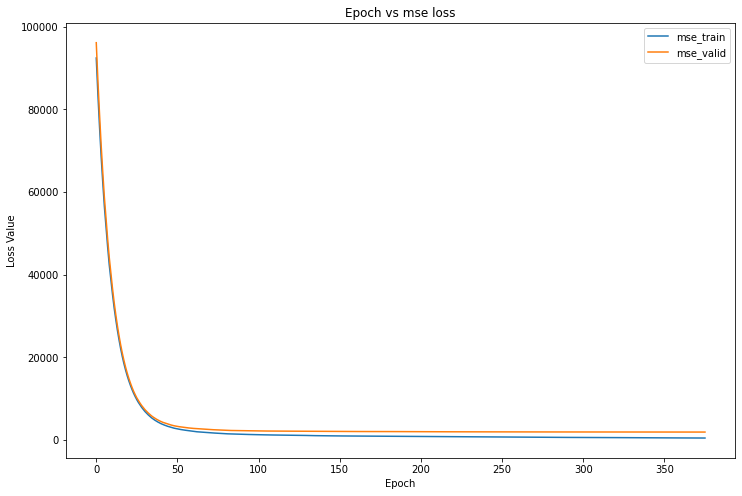

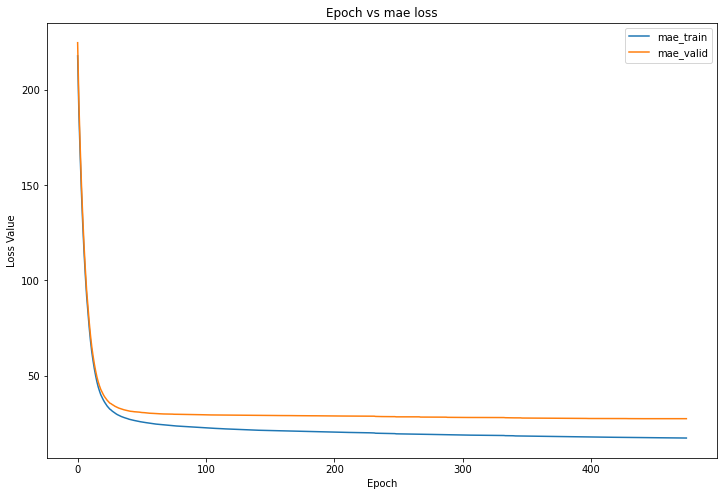

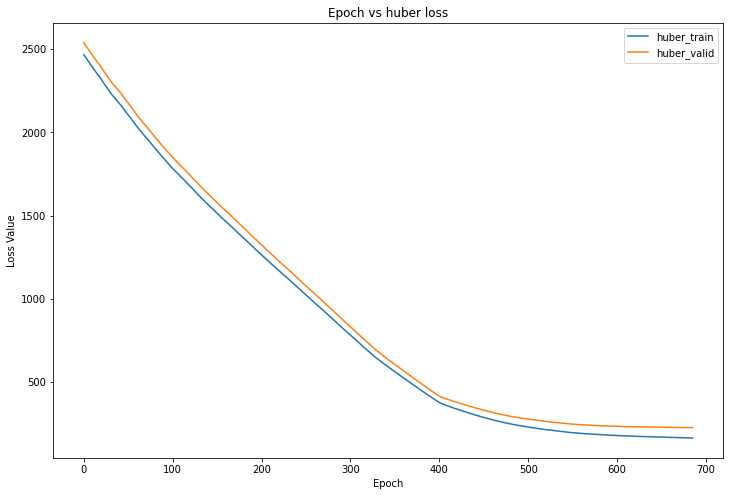

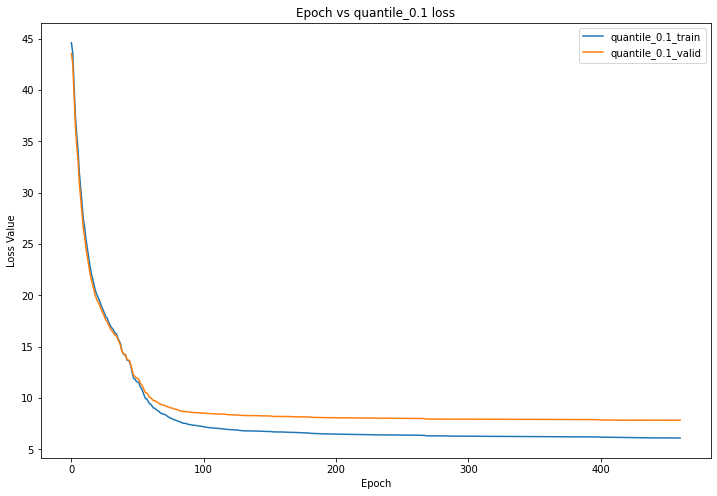

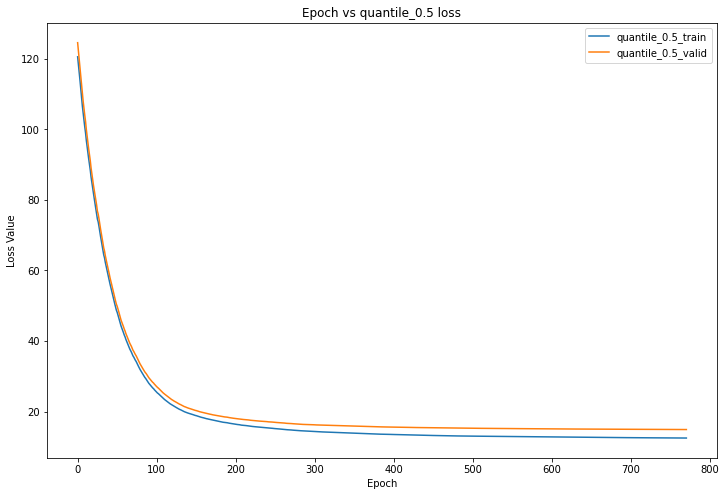

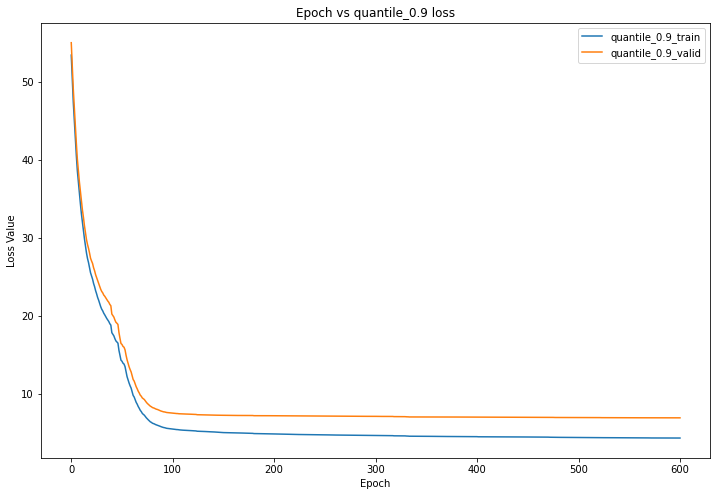

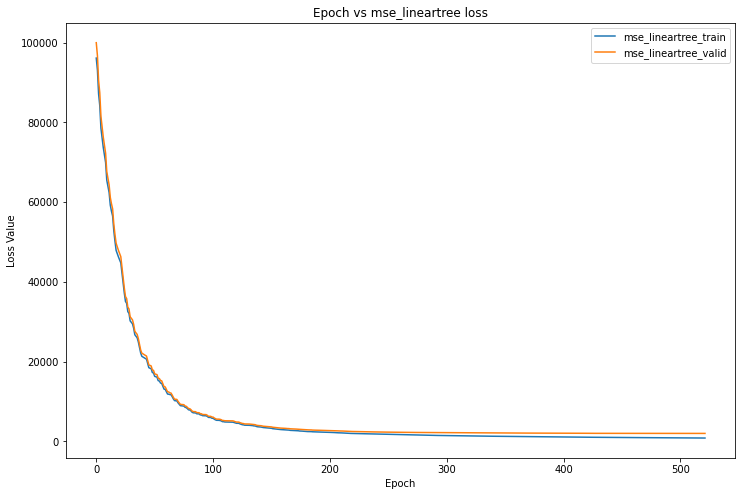

In [19]:
for name, hist in history_list.items():
    plt.figure(figsize=(12,8))
    x_len = len(hist['train'])
    x1 = [x for x in range(x_len)]
    x_len = len(hist['valid'])
    x2 = [x for x in range(x_len)]
    plt.plot(x1, hist['train'], label = name + '_train')
    plt.plot(x2, hist['valid'], label = name + '_valid')
    plt.title('Epoch vs ' + name + ' loss');
    plt.xlabel('Epoch');
    plt.ylabel('Loss Value');
    plt.legend();

### Prediction Results

In [20]:
def plot_prediction(dataframe, flightno, param, min_t=0, max_t=-1, extra = False):
    """
    This function plots parameter against time for given flight number.
    """
    for flno in flightno:
        plotdata = dataframe.loc[dataframe['flight'] == flno].copy()
        t = plotdata['time'] - float(plotdata['time'].head(n=1))
        name = plotdata['drone_type'].iloc[0]
        y = plotdata['battery_power']
        plt.scatter(t[min_t:max_t], y[min_t:max_t],
                    label = 'flight ' + str(flno) + ' ground truth', marker = 'o', c='k', s = 5)
        print(f'{name} flight {flno} battery_power mean: {float(y.mean()):.2f}')
        print(f'{name} flight {flno} battery_power std: {float(y.std()):.2f}')
        
        for var in param:
            if var == 'quantile_0.5':
                name = plotdata['drone_type'].iloc[0]
                y1 = plotdata['quantile_0.1']
                y2 = plotdata['quantile_0.5']
                y3 = plotdata['quantile_0.9']
                plt.fill_between(t[min_t:max_t], y1[min_t:max_t], y3[min_t:max_t], 
                                 alpha=0.5, interpolate = True)
                plt.plot(t[min_t:max_t], y2[min_t:max_t], 
                         label =  name + ' flight ' + str(flno) + ', ' + var, linestyle = '--', linewidth=2)
 
    
            elif var in ['mse', 'mse_lineartree', 'mae', 'huber', 'xgb', 'lgb']:
                #plot prediction
                name = plotdata['drone_type'].iloc[0]
                y = plotdata[var]
                plt.plot(t[min_t:max_t], y[min_t:max_t], 
                         label =  name + ' flight ' + str(flno) + ', ' + var, linestyle = '--', linewidth=2)
                
                if extra:  #if all null, return True
                    if not plotdata[var + '_extra'].isnull().values.all():
                        #plot extrapolated points
                        name = plotdata['drone_type'].iloc[0]
                        y = plotdata[var + '_extra']
                        plt.scatter(t[min_t:max_t], y[min_t:max_t], 
                                    label = name + ' flight ' + str(flno) + ', ' + var + ' extrapolated', marker = 'x', s = 150, color = 'r')
                
    plt.ylabel('Battery Power (W)')
    plt.xlabel('Time (s)')
    plt.legend()
    
    
def plot_residual(model, model_name, dataframe, drone):
    """
    This function takes the model and drone type. Returns 
    the residual plot of all data for that drone type
    """
    temp = dataframe[dataframe['drone_type']== drone].copy()
    all_feature =temp[features]
    y_pred = model.predict(all_feature)
    residual = y_pred - temp['battery_power']
    max_val = np.max(temp['battery_power'])
    plt.scatter(x=temp['battery_power'], y=residual, marker = 'o', s = 5, label = model_name)
    plt.hlines(y=0, xmin=0, xmax=max_val, linewidth=2, linestyle = '--', color='k')
    plt.title('Residual Plot for ' + drone + ' dataset')
    plt.xlabel('Predicted Power');
    plt.ylabel('Standardized Residual');
    plt.legend();

In [21]:
flight_list = [1, 301, 402, 501]

all_data = filtered_df[filtered_df['flight'].isin(flight_list)].copy()
all_feature = all_data[features]

for name, model in model_list.items():
    all_data[name] = model.predict(all_feature)

### Matrice 100 Result

General observation:

1. For all loss function, the model is generally a good fit
2. The quantile model predicts a small band and thus the confidence interval is good.
3. Residual plot has homoscedasticity (residual has equal variance as power increases)

matrice_100 flight 1 battery_power mean: 388.40
matrice_100 flight 1 battery_power std: 178.15
matrice_100 flight 1 battery_power mean: 388.40
matrice_100 flight 1 battery_power std: 178.15


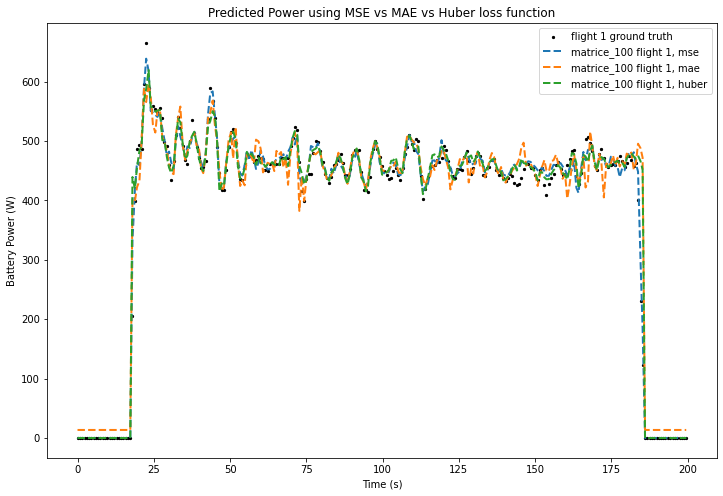

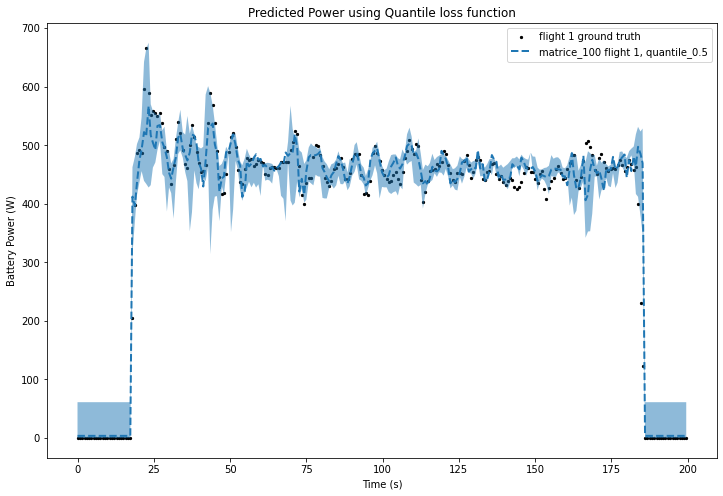

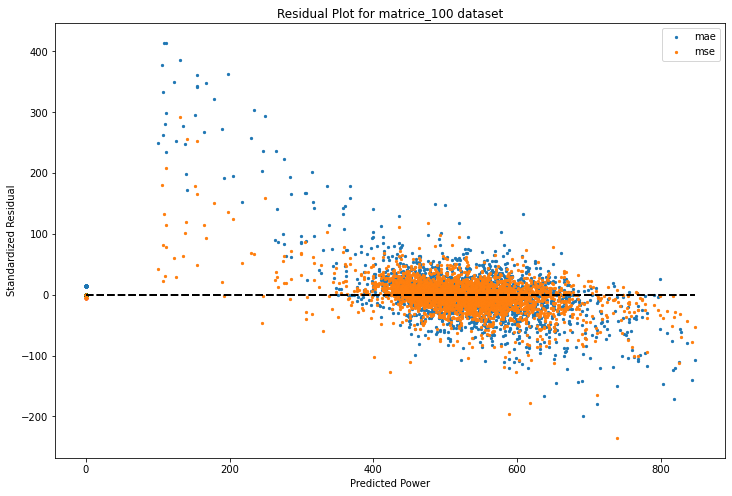

In [22]:
plt.figure(figsize=(12,8))
plot_param = labels + ['mse', 'mae', 'huber']
plot_prediction(all_data, [1], plot_param)
plt.title('Predicted Power using MSE vs MAE vs Huber loss function');

plt.figure(figsize=(12,8))
plot_param = labels + ['quantile_0.5']
plot_prediction(all_data, [1], plot_param)
plt.title('Predicted Power using Quantile loss function');

#plot residual
drone = 'matrice_100'
plt.figure(figsize=(12, 8));
plot_residual(model_list['mae'], 'mae', filtered_df, drone)
plot_residual(model_list['mse'], 'mse', filtered_df, drone)

### Matrice 600 Result

General observation:

1. The MSE loss is able to predict outlier points near 500 seconds
2. For all loss function, the predicted function may be overfitted. This may be caused by noise in the input variables or suboptimal tree structure.
3. The quantile model predicts a small band and thus the confidence interval is good.
4. Residual plot has homoscedasticity around the mean power value. The skew is caused by outlier at zero power.

matrice_600 flight 301 battery_power mean: 961.01
matrice_600 flight 301 battery_power std: 128.12
matrice_600 flight 301 battery_power mean: 961.01
matrice_600 flight 301 battery_power std: 128.12


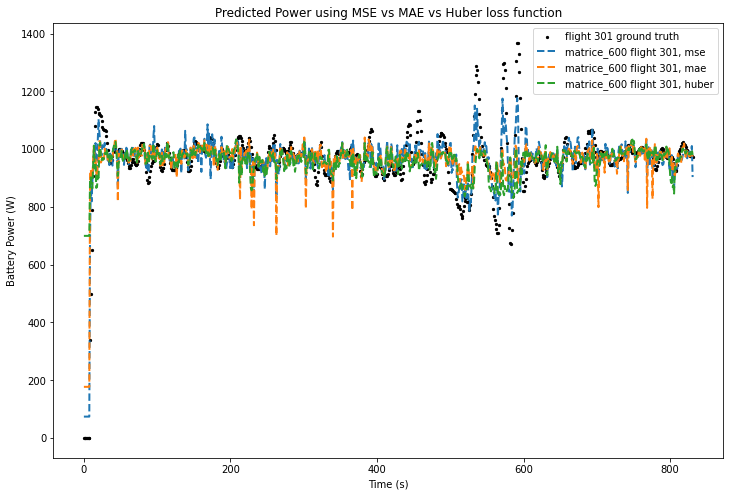

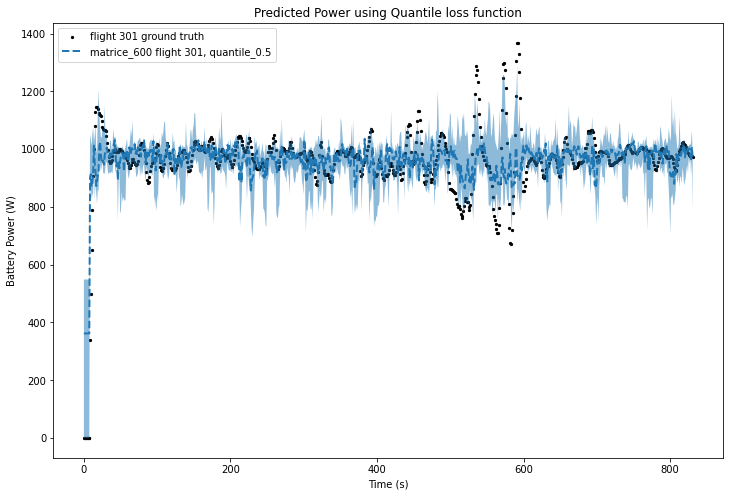

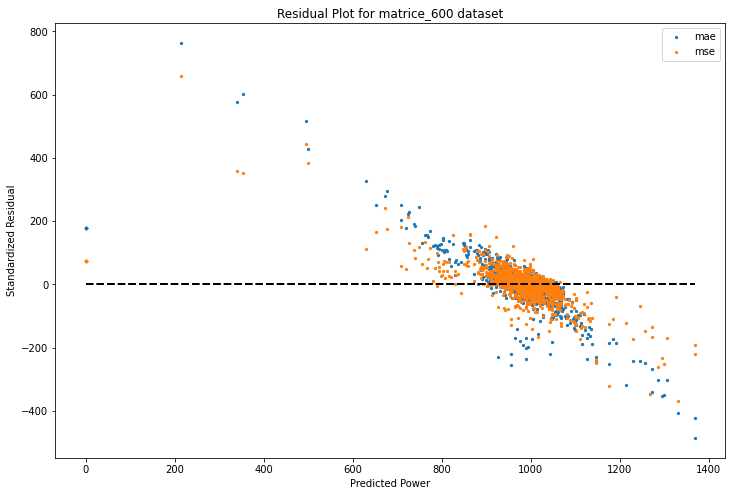

In [23]:
  plt.figure(figsize=(12,8))
plot_param = labels + ['mse', 'mae', 'huber']
plot_prediction(all_data, [301], plot_param)
plt.title('Predicted Power using MSE vs MAE vs Huber loss function');

plt.figure(figsize=(12,8))
plot_param = labels + ['quantile_0.5']
plot_prediction(all_data, [301], plot_param)
plt.title('Predicted Power using Quantile loss function');

#plot residual
drone = 'matrice_600'
plt.figure(figsize=(12, 8));
plot_residual(model_list['mae'], 'mae', filtered_df, drone)
plot_residual(model_list['mse'], 'mse', filtered_df, drone)

### Mavic Result

General observation:

1. For all loss function, the model does poorly. This is the result of poor interpolation of the model caused by suboptimal tree structure. The main reason, likely due to insufficient data, is further analyzed in the tree structure below.
2. The quantile model predicts a small band and thus the confidence interval is good.
4. Residual plot has obvious homoscedasticity.

mavic flight 402 battery_power mean: 85.12
mavic flight 402 battery_power std: 26.36
mavic flight 402 battery_power mean: 85.12
mavic flight 402 battery_power std: 26.36


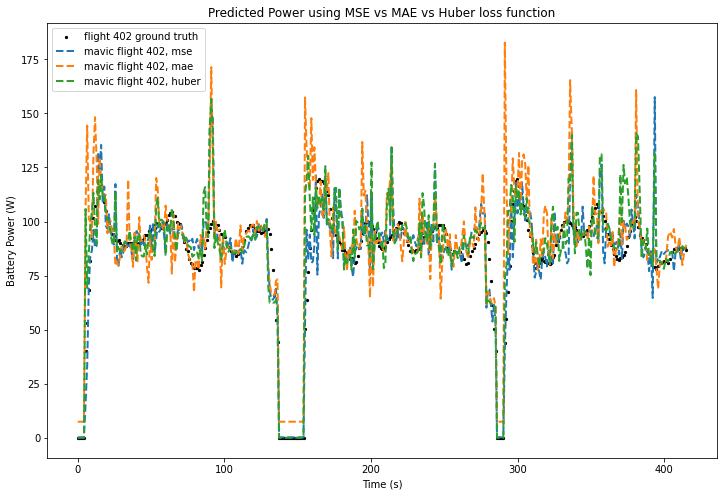

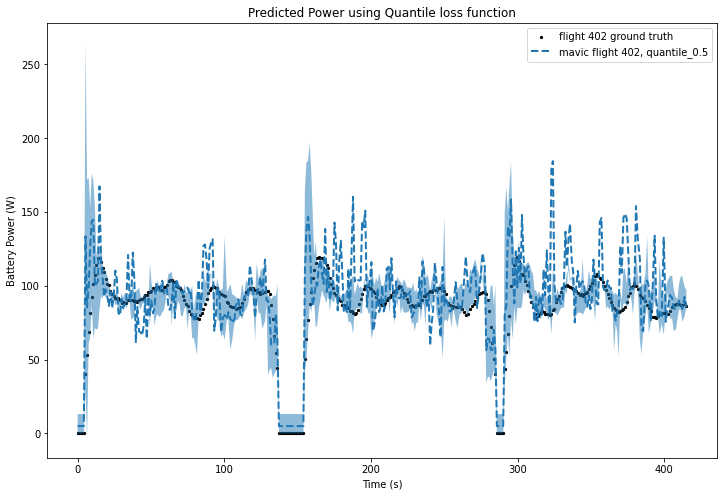

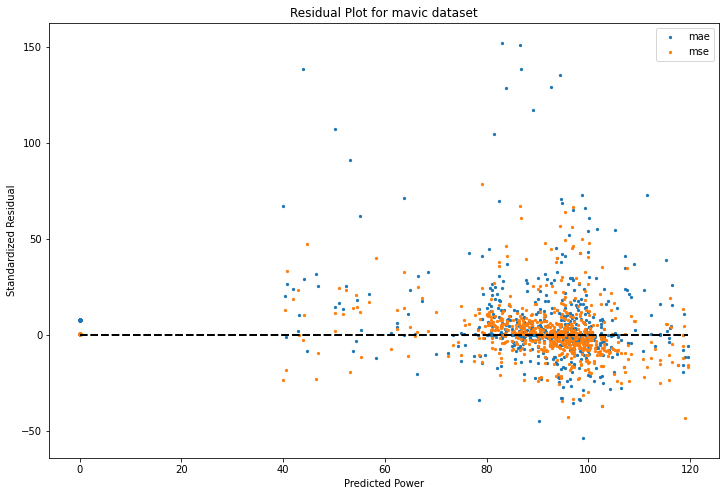

In [24]:
plt.figure(figsize=(12,8))
plot_param = labels + ['mse', 'mae', 'huber']
plot_prediction(all_data, [402], plot_param)
plt.title('Predicted Power using MSE vs MAE vs Huber loss function');

plt.figure(figsize=(12,8))
plot_param = labels + ['quantile_0.5']
plot_prediction(all_data, [402], plot_param)
plt.title('Predicted Power using Quantile loss function');

#plot residual
drone = 'mavic'
plt.figure(figsize=(12, 8));
plot_residual(model_list['mae'], 'mae', filtered_df, drone)
plot_residual(model_list['mse'], 'mse', filtered_df, drone)

### Inspire Result

General observation:

1. The MSE loss is able to predict outlier points better than other loss function. 
2. For all loss function, the model is generally a good fit.
3. The quantile model predicts a large band around 200 to 300 seconds and thus the confidence interval is poor. This is likely due to the variance of the input variables. It is not caused by suboptimal tree structure as the quantile of $\alpha=0.5$ does a relatively good job at fitting.
4. Residual plot has homoscedasticity around the mean power value. There are a few points caused by outlier at zero power.

inspire flight 501 battery_power mean: 309.51
inspire flight 501 battery_power std: 142.26
inspire flight 501 battery_power mean: 309.51
inspire flight 501 battery_power std: 142.26


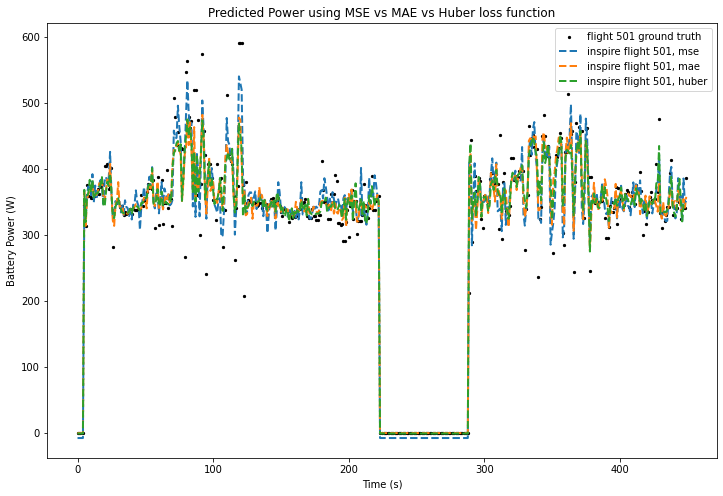

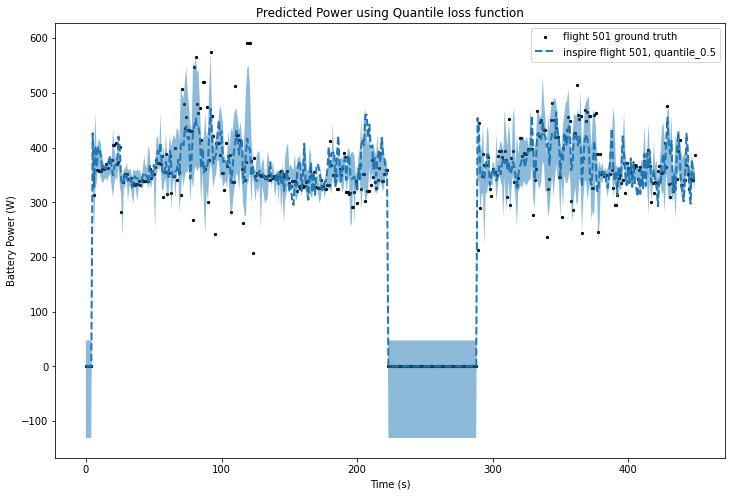

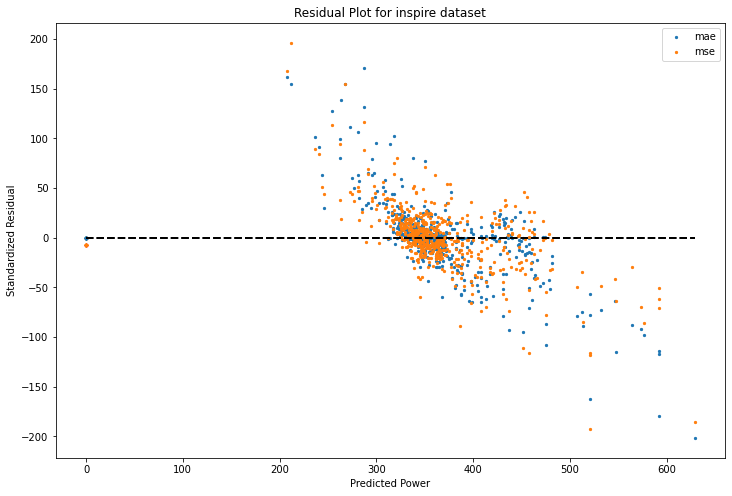

In [25]:
plt.figure(figsize=(12,8))
plot_param = labels + ['mse', 'mae', 'huber']
plot_prediction(all_data, [501], plot_param)
plt.title('Predicted Power using MSE vs MAE vs Huber loss function');

plt.figure(figsize=(12,8))
plot_param = labels + ['quantile_0.5']
plot_prediction(all_data, [501], plot_param)
plt.title('Predicted Power using Quantile loss function');

#plot residual
drone = 'inspire'
plt.figure(figsize=(12, 8));
plot_residual(model_list['mae'], 'mae', filtered_df, drone)
plot_residual(model_list['mse'], 'mse', filtered_df, drone)

### Tree Structure

The tree structure for MAE loss function is plotted. Note, there are >100 trees and not all of them can be plotted. Therefore, only tree index 0 is plotted. 


General Observations from Tree Structure:

1. The top nodes that appear in the tree structure are total mass, wind_N, v_E. These variables are easiest to split the data according to the algorithm.
2. From feature importance, the most important variables are v_D and a_D. This is also expected because the drone energy is highly influenced by its weight in a gravitational field. 
3. For tree index 0, most of the leaf value are 300 to 400. These leaf value indicates the power predicted by weak trees and is added with other trees to predict the final power. This range also corresponds to the power of Matrice 100 and Inspire dataset. The split is expected as large percentage of the data comes from Matrice 100 and it is the median power among the drone types.
4. Leaf split is not equal across different drone type as shown by the weak trees. For instance, there are no further branches for $mass \gt 3.263$ which could correspond to Matrice 600. Unequal splitting may cause the model to generalize poorly for other drone types. Suboptimal tree structures can also be seen from the time graph which tends to overfit data. One possible reason could be that there is insufficient data / class imbalance leading to suboptimal split.

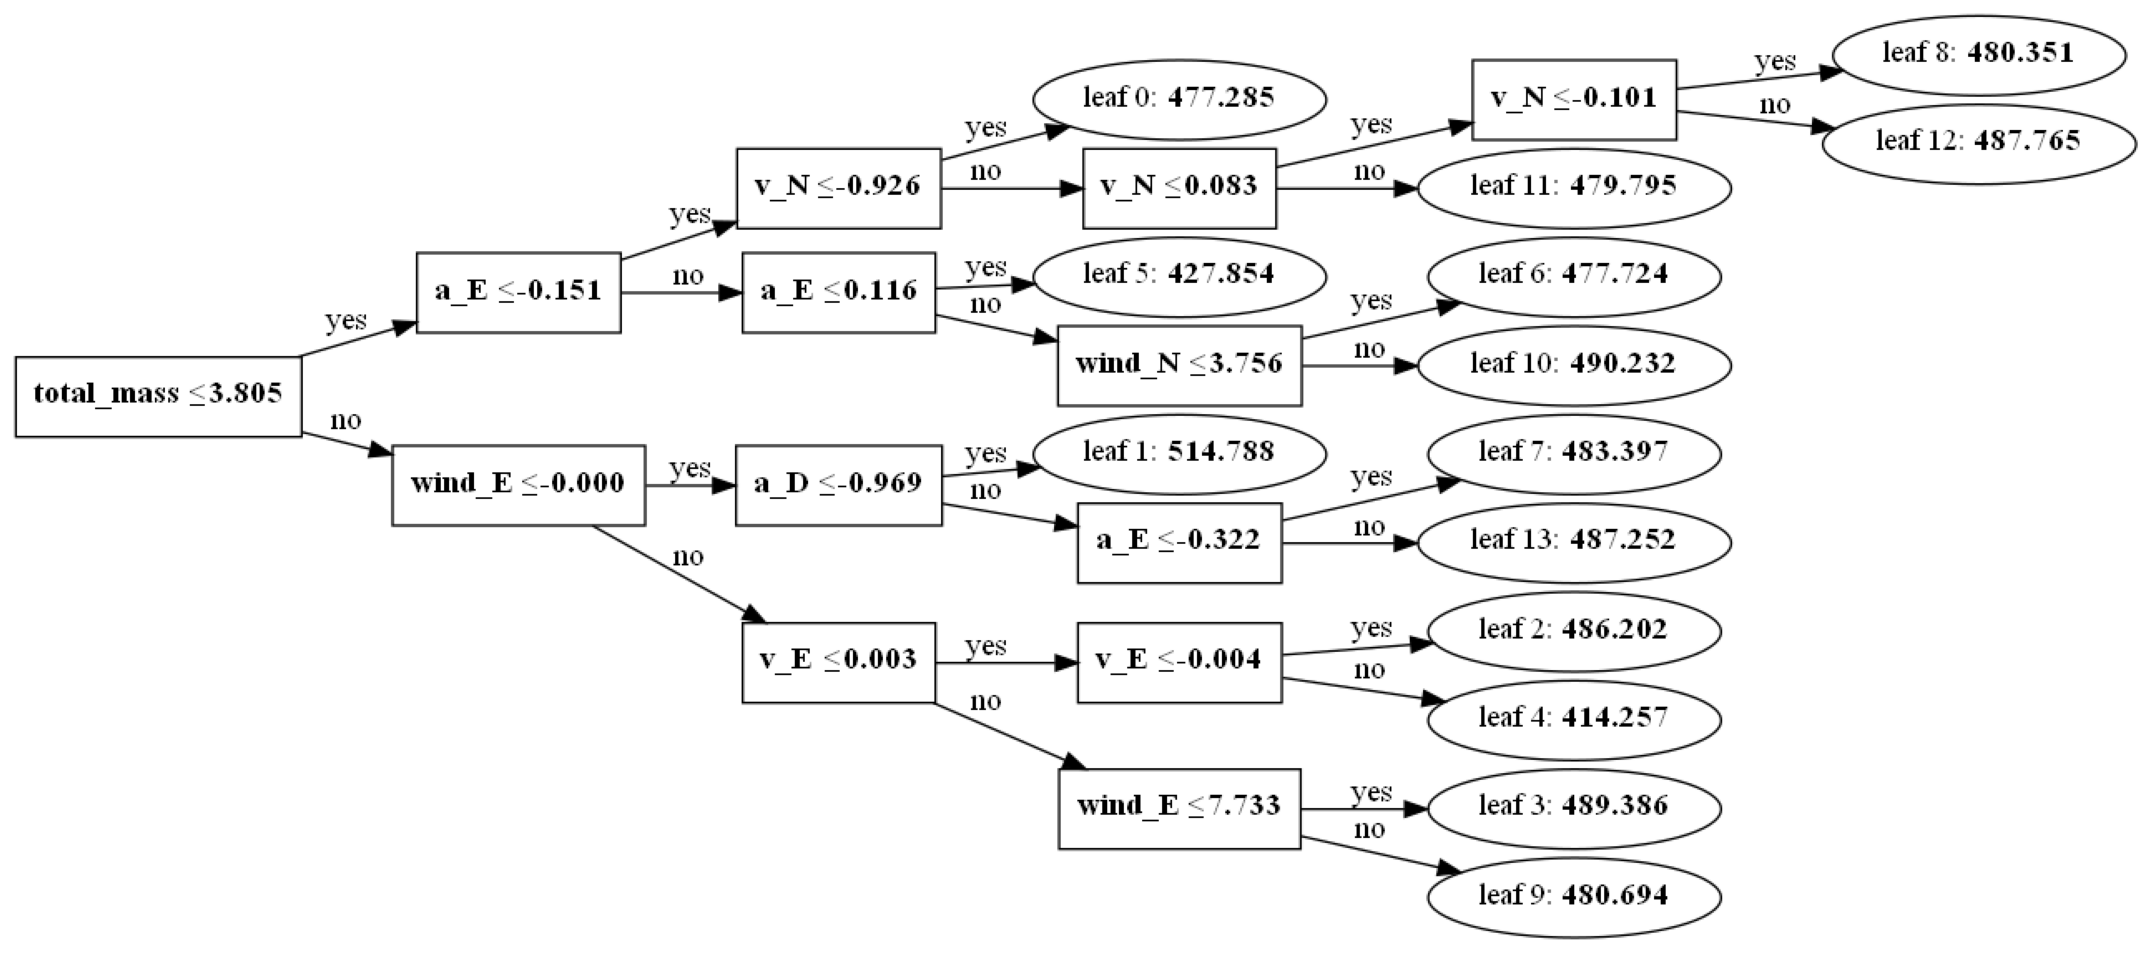

In [26]:
ax = lgb.plot_tree(model_list['mae'], figsize=(30,30))
ax.figure.tight_layout()
ax.figure.savefig('MAE_tree_0.png')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

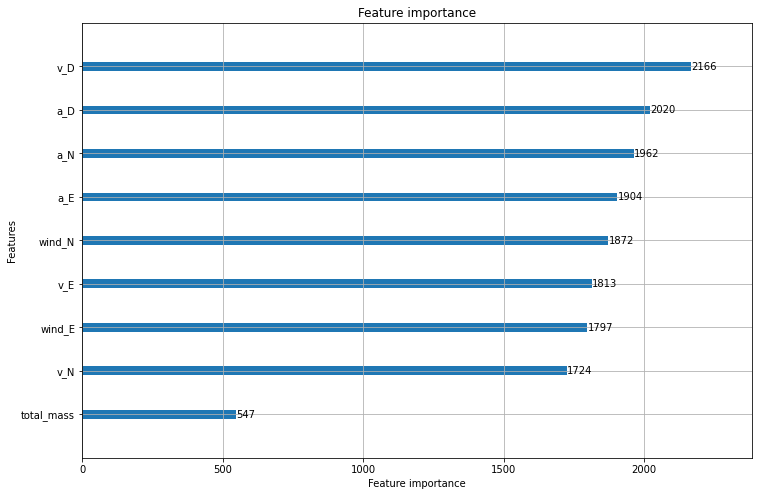

In [27]:
lgb.plot_importance(model_list['mae'], figsize=(12,8))

### Detecting Extrapolation

One possible method to detect extrapolation is to keep track of the range of values inside the training data. For instance, taking the minimum and maximum value of each variable while training. Then, check each variable with the training range during the prediction step. The `label_extrapolation` and `get_extrapolation_range` function is implemented below. The interpolation value is shown for each drone type as a tuple (min, max) in the table. To illustrate extrapolation errors, the train validation split was increased from 0.2 to 0.5 to simulate lack of training data points.

In [28]:
def get_interpolation_range(x_train, drone_list):
    """
    Returns the range of values for each feature variable in the training set
    """
    range_dict = {}
    for drone in np.unique(drone_list):
        idx = np.where(drone_list == drone)
        temp = x_train.iloc[idx]
        variable_dict = {}
        for variable in temp.columns:
            min_val = round(temp.loc[:, variable].min(),2)
            max_val = round(temp.loc[:, variable].max(),2)
            variable_dict[variable] = (min_val, max_val)
        range_dict[drone] = variable_dict
    return range_dict
    
    
def label_extrapolation(x_test, range_dict):
    """
    Assign 1 if the test point is out of interpolation range
    Assign 0 if the test point is within interpolation range
    Evaluate truth value per row using OR
    Return the positional index where the row is True corresponding to x_test
    """
    temp = x_test.copy()
    for variable, rng in range_dict.items():
        temp[variable+'check'] = temp[variable].apply(lambda x: 1 if x < rng[0]-0.01 or x > rng[1]+0.01 else 0)
    check_cols = temp[[x+'check' for x in range_dict.keys()]]
    truth_array = np.any(check_cols, axis = 1)
    truth_index = np.where(truth_array == 1)
    return truth_index

rng_dict = get_interpolation_range(X_train, X_train_group)
summary2 = pd.DataFrame.from_dict(rng_dict, orient = 'index')
#display(Latex(summary2.to_latex()))
summary2

v_N             v_E            v_D            a_N  \
inspire       (-0.91, 0.86)   (-1.28, 1.41)  (-4.41, 4.06)  (-0.04, 0.06)   
matrice_100   (-4.62, 9.04)   (-9.36, 9.97)  (-3.58, 3.64)   (-4.0, 4.41)   
matrice_600  (-9.43, 10.36)  (-11.01, 9.12)  (-4.91, 2.94)  (-0.16, 0.24)   
mavic         (-3.28, 3.96)    (-9.05, 4.6)   (-3.32, 3.0)  (-0.23, 0.14)   

                       a_E             a_D          wind_N           wind_E  \
inspire       (-0.08, 0.1)  (-1.38, -0.73)      (nan, nan)       (nan, nan)   
matrice_100   (-3.4, 4.48)  (-1.13, -0.85)  (-13.76, 12.4)  (-13.27, 11.03)   
matrice_600  (-0.17, 0.09)  (-1.28, -0.73)      (nan, nan)       (nan, nan)   
mavic        (-0.12, 0.12)  (-1.11, -0.76)    (-5.17, 0.0)    (-0.91, 4.83)   

               total_mass  
inspire      (2.84, 2.84)  
matrice_100  (3.68, 4.43)  
matrice_600    (9.1, 9.1)  
mavic        (0.73, 0.73)

matrice_100 flight 1 battery_power mean: 388.40
matrice_100 flight 1 battery_power std: 178.15
matrice_600 flight 301 battery_power mean: 961.01
matrice_600 flight 301 battery_power std: 128.12
mavic flight 402 battery_power mean: 85.12
mavic flight 402 battery_power std: 26.36
inspire flight 501 battery_power mean: 309.51
inspire flight 501 battery_power std: 142.26


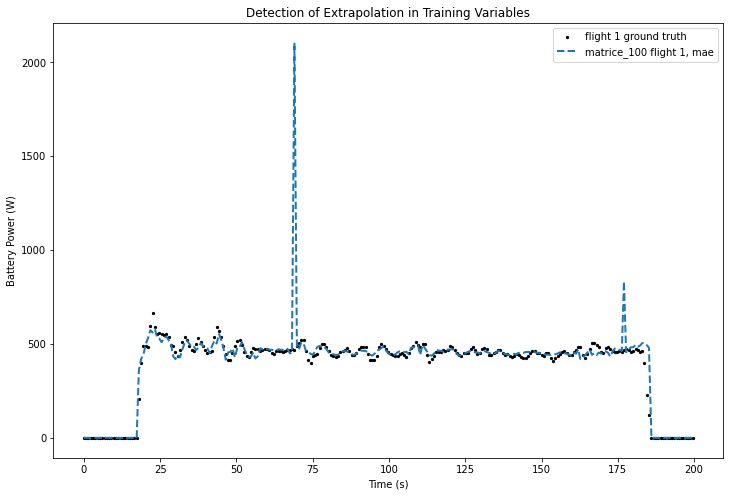

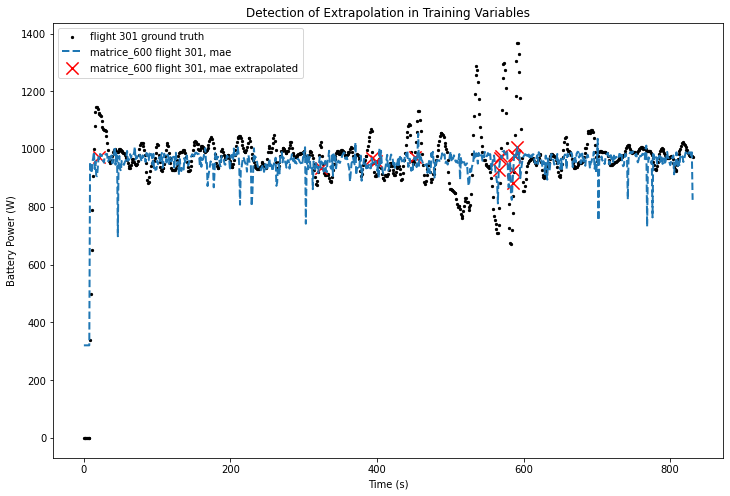

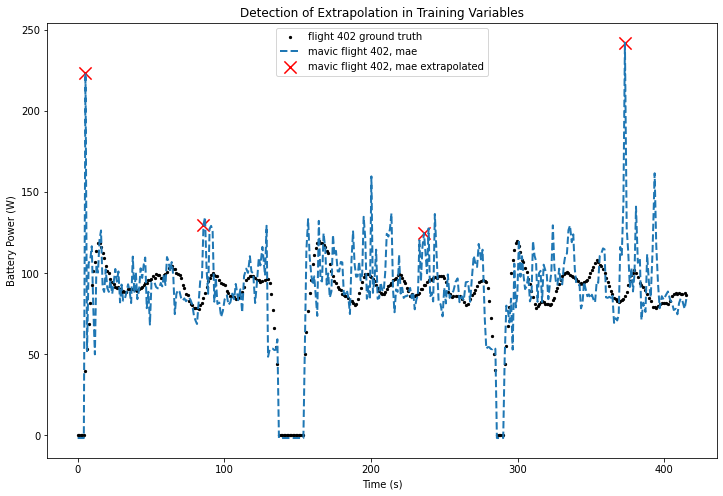

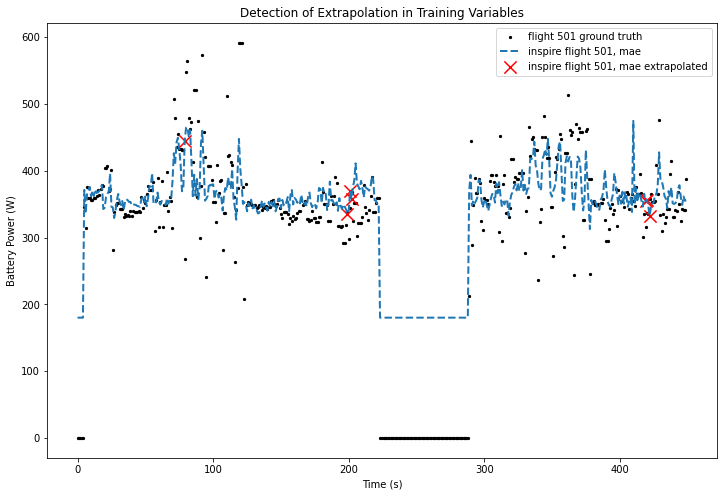

In [29]:
#split validation set
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.5, stratify = X_train_group, shuffle = True)
grp = drone_group.loc[x_train.index]
#train new model
model, history = train_LGBM(param, x_train, x_valid, y_train, y_valid)
#get new range
rng_dict_sim = get_interpolation_range(x_train, grp)

flight_list = [1, 301, 402, 501]
#predict for full flight
for flno in flight_list:
    test_data = filtered_df[filtered_df['flight']==flno].copy()
    drone = np.unique(test_data['drone_type'])[0]
    test_feature = test_data[features]
    test_data['mae'] = model.predict(test_feature)
    idx = label_extrapolation(test_feature, rng_dict_sim[drone])
    extrapolated_points = test_data['mae'].iloc[idx]
    test_data['mae_extra'] = extrapolated_points
    #plot
    plt.figure(figsize=(12,8))
    plot_param = labels + ['mae']
    plot_prediction(test_data, [flno], plot_param, 0, -1, True)
    plt.title('Detection of Extrapolation in Training Variables');

General Observations:

1. Due to round-off errors, a tolerance of 0.01 was added to check the variable range. At these extrapolated points, at least one of the variable in X exceeds the training range.
2. For a training size of 50%, there are only a few extrapolated points for Matrice 600, mavic and inspire. Decreasing the training size will increase extrapolation errors. 
3. It is noted that interpolation errors are more significant than extrapolation errors when training size is large. The interpolated errors are caused by outliers and variance of the input variables, while extrapolation are due to missing/lack of data.

## Optimizing XGBoost

The default class constructor `XGBRegressor` will be used. It automatically initializes model parameters and allow `fit`, `train` and `predict` methods. The procedure for implementing XGBoost is the same as LightGBM. Only the MSE loss function (but evaluated with MAE score) will be used to compare with LightGBM.

In [30]:
def XGB_tune_objective(trial: Trial):
    """
    This function takes the trial object from Optuna and uses the TPE algorithm
    to sample the hyperparameters. Returns the history of validation score to 
    Optuna for pruning.
    """
    #split train-test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = drone_group, shuffle = True, random_state = test_seed)
    X_train_drone_group = drone_group.loc[X_train.index]
    
    #split validation set
    x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2, stratify = X_train_drone_group, shuffle = True, random_state = valid_seed)

    #train model
    model, history = xgb_fit(trial, x_train, x_valid, y_train, y_valid)
    
    #get validation score
    valid_score = history['valid']
    
    #return score to optuna
    return valid_score

def xgb_fit(trial, x_train, x_valid, y_train, y_valid):
    """
    This function takes the trial, train and validation set. 
    Return the trained model and history of validation score.
    """
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        #PARAM THAT AFFECT TREE STRUCTURE
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 5, 8),
        #PARAM THAT AFFECT LEAF-WISE SPLITTING
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1.0, log = True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0, step = 0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step = 0.1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0, step = 0.1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0, step = 0.1),
        #PARAM THAT AFFECT REGULARIZATION
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 100.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 100.0)
    }
    
    #instantiate model
    model = xgb.XGBRegressor(**param)
    eval_set = [(x_train, y_train),(x_valid, y_valid)]
    
    #early callback via median pruning
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, observation_key = 'validation_1-mae')
    
    #train
    model.fit(x_train, y_train, eval_set=eval_set, callbacks=[pruning_callback], verbose = False)
    history = {'train': np.min(model.evals_result()['validation_0']['mae']),
               'valid': np.min(model.evals_result()['validation_1']['mae'])}

    return model, history

In [31]:
%%time
#create pruner
XGB_pruner = optuna.pruners.MedianPruner(n_startup_trials = 50, n_warmup_steps= 5)
#create study (default sampler = TPE, objective = MAE) 
XGB_study1 = optuna.create_study(pruner=XGB_pruner, direction ='minimize')
XGB_study1.optimize(XGB_tune_objective, n_trials = 100);

[I 2022-03-25 10:54:03,498] A new study created in memory with name: no-name-d2ed2e8f-4d7c-4460-983a-31c30d2e3ed3
[I 2022-03-25 10:54:03,713] Trial 0 finished with value: 132.161942 and parameters: {'n_estimators': 130, 'max_depth': 7, 'learning_rate': 0.021293936227703283, 'min_child_weight': 1.104303521656818, 'subsample': 0.1, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.2, 'colsample_bynode': 0.2, 'reg_alpha': 50.679075988884215, 'reg_lambda': 57.1487856390827}. Best is trial 0 with value: 132.161942.
[I 2022-03-25 10:54:04,446] Trial 1 finished with value: 31.372755 and parameters: {'n_estimators': 310, 'max_depth': 7, 'learning_rate': 0.8794382157546072, 'min_child_weight': 6.047459402504186, 'subsample': 0.9, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.30000000000000004, 'reg_alpha': 43.2548345634934, 'reg_lambda': 58.047231929462804}. Best is trial 1 with value: 31.372755.
[I 2022-03-25 10:54:05,276] Trial 2 finished with value: 406.045044 and pa

[I 2022-03-25 10:54:24,225] Trial 20 finished with value: 30.754803 and parameters: {'n_estimators': 646, 'max_depth': 6, 'learning_rate': 0.21522140790884076, 'min_child_weight': 5.443097868633484, 'subsample': 0.5, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.4, 'colsample_bynode': 0.9, 'reg_alpha': 84.41432371420058, 'reg_lambda': 12.29069243722467}. Best is trial 19 with value: 24.112835.
[I 2022-03-25 10:54:26,098] Trial 21 finished with value: 23.781155 and parameters: {'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.13570188760250457, 'min_child_weight': 3.937256101425988, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'colsample_bynode': 1.0, 'reg_alpha': 59.33806668905274, 'reg_lambda': 88.83724338822002}. Best is trial 21 with value: 23.781155.
[I 2022-03-25 10:54:27,397] Trial 22 finished with value: 44.325352 and parameters: {'n_estimators': 785, 'max_depth': 6, 'learning_rate': 0.009729569064665253, 'min_child_weight': 3.510

[I 2022-03-25 10:54:48,722] Trial 40 finished with value: 444.902008 and parameters: {'n_estimators': 398, 'max_depth': 8, 'learning_rate': 4.213246886950515e-06, 'min_child_weight': 4.9444275620708416, 'subsample': 0.9, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'colsample_bynode': 0.7000000000000001, 'reg_alpha': 69.49925336859859, 'reg_lambda': 23.42480293527027}. Best is trial 21 with value: 23.781155.
[I 2022-03-25 10:54:50,264] Trial 41 finished with value: 24.874077 and parameters: {'n_estimators': 746, 'max_depth': 5, 'learning_rate': 0.12243987745663472, 'min_child_weight': 3.9759737169413145, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'colsample_bynode': 1.0, 'reg_alpha': 55.531723434499725, 'reg_lambda': 89.43818131940378}. Best is trial 21 with value: 23.781155.
[I 2022-03-25 10:54:51,811] Trial 42 finished with value: 27.077435 and parameters: {'n_estimators': 799, 'max_depth': 5, 'learning_rate': 0.44436934353806834, 'min_child_weight': 4

[I 2022-03-25 10:55:24,657] Trial 69 finished with value: 23.948484 and parameters: {'n_estimators': 704, 'max_depth': 7, 'learning_rate': 0.28274074563852514, 'min_child_weight': 6.839024176075362, 'subsample': 0.8, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.9, 'reg_alpha': 66.65287622560709, 'reg_lambda': 3.8730133928798267}. Best is trial 68 with value: 22.991426.
[I 2022-03-25 10:55:26,106] Trial 70 pruned. Trial was pruned at iteration 483.
[I 2022-03-25 10:55:28,656] Trial 71 finished with value: 24.769049 and parameters: {'n_estimators': 709, 'max_depth': 7, 'learning_rate': 0.3019265532164993, 'min_child_weight': 7.863836126791677, 'subsample': 0.8, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.9, 'reg_alpha': 68.35197322456565, 'reg_lambda': 13.421097550007019}. Best is trial 68 with value: 22.991426.
[I 2022-03-25 10:55:31,028] Trial 72 finished with value: 24.513556 and parameters: {'n_estimators': 677, 'max_depth': 7,

Wall time: 2min 2s


In [32]:
print('Hyperparameters: \n \n', XGB_study1.best_trial.params)
print('\n')
print('Best MSE Value: \n \n', XGB_study1.best_trial.value)
fig1 = optuna.visualization.plot_optimization_history(XGB_study1, target_name="Mean Absolute Error")
fig1.show()
fig2 = optuna.visualization.plot_param_importances(XGB_study1, target_name="Mean Absolute Error")
fig2.show()

Hyperparameters: 
 
 {'n_estimators': 699, 'max_depth': 7, 'learning_rate': 0.30322929427452694, 'min_child_weight': 4.771880111379894, 'subsample': 0.8, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'reg_alpha': 66.62202154416109, 'reg_lambda': 91.36684296548214}


Best MSE Value: 
 
 22.991426


In [33]:
best_params = XGB_study1.best_trial.params

def train_XGB(best_params, x_train, x_valid, y_train, y_valid):
    """
    Returns a trained LightGBM model using the best hyperparameter
    """
    #instantiate model
    model = xgb.XGBRegressor(**best_params)
    eval_set = [(x_valid,y_valid)]
    
    #train
    model.fit(x_train, y_train, eval_set = eval_set, verbose = False)
    
    return model

#split train-test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = drone_group, shuffle = True, random_state = test_seed)
X_train_group = drone_group.loc[X_train.index]

#split train-validation set
x_train, x_valid, y_train, y_valid =  train_test_split(X_train, Y_train, test_size = 0.2, stratify = X_train_group, shuffle = True, random_state = valid_seed)

#train model
model = train_XGB(best_params, x_train, x_valid, y_train, y_valid)
model_list['xgb'] = model

#predict
Y_test_pred = model.predict(X_test)

#evaluate score on test set
r2_test_score = r2_score(y_true = Y_test, y_pred = Y_test_pred)
mse_test_score = mean_squared_error(y_true = Y_test, y_pred = Y_test_pred)
mae_test_score = mean_absolute_error(y_true = Y_test, y_pred = Y_test_pred)

print(f"The R2 score is {r2_test_score}. The MSE score is {mse_test_score}. The MAE score is {mae_test_score}")

The R2 score is 0.9810619233410484. The MSE score is 2028.383724825916. The MAE score is 24.714936663201136


mavic flight 402 battery_power mean: 85.12
mavic flight 402 battery_power std: 26.36
inspire flight 501 battery_power mean: 309.51
inspire flight 501 battery_power std: 142.26


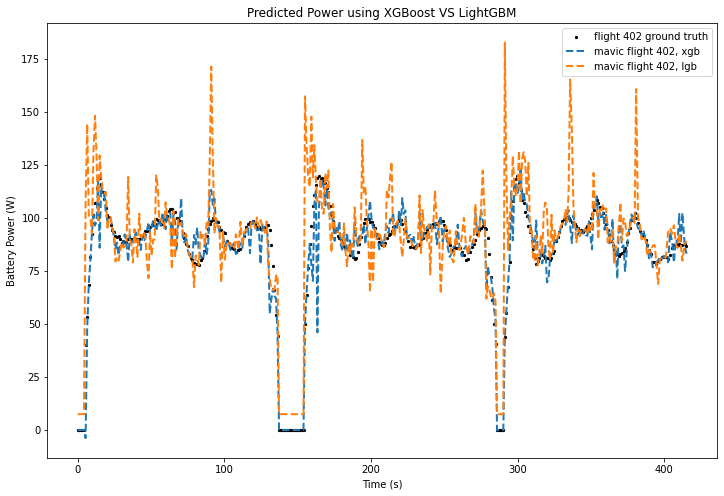

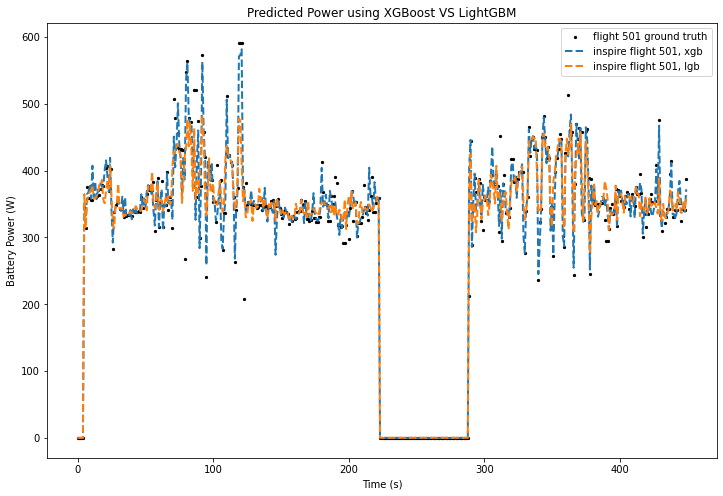

In [34]:
flight_list = [402, 501]

test_data = filtered_df[filtered_df['flight'].isin(flight_list)].copy()
test_feature = test_data[features]

test_data['lgb'] = model_list['mae'].predict(test_feature)
test_data['xgb'] = model_list['xgb'].predict(test_feature)

plt.figure(figsize=(12,8))
plot_param = labels + ['xgb', 'lgb']
plot_prediction(test_data, [402], plot_param)
plt.title('Predicted Power using XGBoost VS LightGBM');
    
plt.figure(figsize=(12,8))
plot_param = labels + ['xgb', 'lgb']
plot_prediction(test_data, [501],plot_param)
plt.title('Predicted Power using XGBoost VS LightGBM');

General Observation of XGBoost:

1. The prediction of XGBoost is similar to LightGBM with sign of overfitting in both flights.
2. There is large difference in training time, with LightGBM being the faster algorithm. This is expected as LightGBM chooses the best node to expand while XGBoost uses depth-first search. 
3. There is not much difference in prediction accuracy on test set for both model.